In [19]:
## 必要なライブラリのimport
import tensorflow as tf
import keras
import pydot
import graphviz
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, concatenate
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import scipy.stats
import math

In [34]:
## データについて

### データファイルのpath
no_hole_path = './../tmp_simulation/tmp_data/no_hole_data.csv'
one_hole_path = './../tmp_simulation/tmp_data/one_hole_data.csv'
four_holes_path = './../tmp_simulation/tmp_data/four_holes_data.csv'
nine_holes_path = './../tmp_simulation/tmp_data/nine_holes_data.csv'
sixteen_holes_path = './../tmp_simulation/tmp_data/sixteen_holes_data.csv'
twentyfive_holes_path = './../tmp_simulation/tmp_data/twentyfive_holes_data.csv'

### 入力データと正解データ
no_hole_data = []
x_size_data = []
x_position_data = []
y_data = []

### ファイル読み込み

#### 欠陥がない場合の温度データ
with open(no_hole_path) as f:
    for line in f:
        no_hole_data = line.split(',')[:-1]

#### データ
with open(one_hole_path) as f1:
  for line in f1:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(four_holes_path) as f2:
  for line in f2:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(nine_holes_path) as f3:
  for line in f3:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(sixteen_holes_path) as f4:
  for line in f4:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(twentyfive_holes_path) as f5:
  for line in f5:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])

### 各配列をnp.array型にして各要素を型変換
no_hole_data = np.array(no_hole_data, dtype=float)
x_size_data = np.array(x_size_data, dtype=float)
x_position_data = np.array(x_position_data, dtype=float)
y_data = np.array(y_data, dtype=float)

### データの加工
y_data = y_data - no_hole_data
max_value = 0
min_value = 0
for i in range(len(y_data)):
    for j in range(len(y_data[i])):
        if max_value < y_data[i][j]:
            max_value = y_data[i][j]
        if min_value > y_data[i][j]:
            min_value = y_data[i][j]
y_data = (y_data-min_value)/(max_value-min_value)
### train用とtest用に分割(4:1)
x_size_train, x_size_test, x_position_train, x_position_test, y_train, y_test = train_test_split(x_size_data, x_position_data, y_data, test_size=0.20)


### reshape
x_size_train = x_size_train.reshape(8108, 1, 1)
x_size_test = x_size_test.reshape(2027, 1, 1)
x_position_train = x_position_train.reshape(8108, 2, 1)
x_position_test = x_position_test.reshape(2027, 2, 1)

In [35]:
print(y_data[0])

[0.8931895  0.89250107 0.89225046 0.88888735 0.88462468 0.87947086
 0.87143721 0.86378117 0.86206154 0.85774351 0.85189447 0.84496902
 0.83823916 0.82655996 0.81775261 0.80560981 0.77369858 0.74816097
 0.74321813 0.71210632 0.66244717 0.68204378 0.77093256 0.77093256
 0.77093256 0.77093256 0.77093256 0.65064489 0.67072593 0.66800866
 0.67687734 0.6957401  0.69648685 0.66965119 0.6623532  0.65736653
 0.65477449 0.64996606 0.65152136 0.64543897 0.64160763 0.64480335
 0.64100609 0.63033825 0.6259155  0.62045912 0.60983468 0.60513632
 0.60184156 0.60077146]


In [36]:
# 入力を定義
size_input = Input(shape=(1,))
position_input = Input(shape=(2,))

# 入力1から結合前まで
x = Dense(1, activation="linear")(size_input)
x = Model(inputs=size_input, outputs=x)

# 入力2から結合前まで
y = Dense(1, activation="linear")(position_input)
y = Model(inputs=position_input, outputs=y)

# 結合
combined = concatenate([x.output, y.output])

# 密結合
z = Dense(128, activation="linear")(combined)
z = Dense(50, activation="linear")(z)

# モデル定義とコンパイル
model = Model(inputs=[x.input, y.input], outputs=z)
model.compile(loss='mse', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1)            2           input_5[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 1)            3           input_6[0][0]                    
____________________________________________________________________________________________

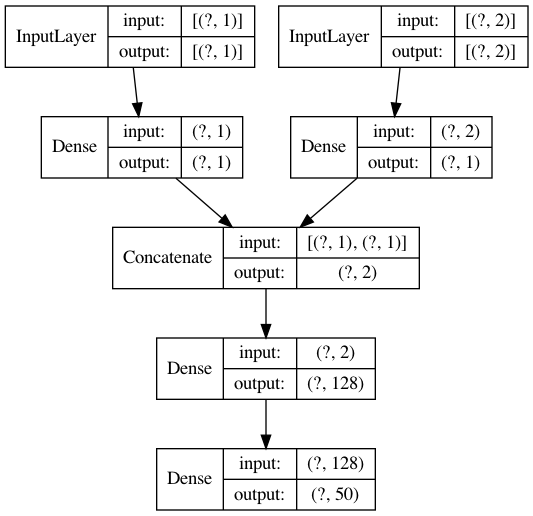

In [37]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [38]:
# 学習
epochs = 2000
batch_size = 128
history = model.fit([x_size_train, x_position_train], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_size_test, x_position_test], y_test))

Epoch 1/2000
64/64 [==============================] - 0s 3ms/step - loss: 0.8166 - acc: 3.7000e-04 - val_loss: 0.0984 - val_acc: 0.0020
Epoch 2/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0566 - acc: 0.0190 - val_loss: 0.0402 - val_acc: 0.1569
Epoch 3/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0347 - acc: 0.1537 - val_loss: 0.0290 - val_acc: 0.1263
Epoch 4/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0247 - acc: 0.0985 - val_loss: 0.0204 - val_acc: 0.1534
Epoch 5/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0171 - acc: 0.0530 - val_loss: 0.0141 - val_acc: 0.1450
Epoch 6/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0115 - acc: 0.0620 - val_loss: 0.0090 - val_acc: 0.0015
Epoch 7/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0075 - acc: 0.0683 - val_loss: 0.0059 - val_acc: 0.0454
Epoch 8/2000
64/64 [==============================] - 0s 2ms/step - loss

64/64 [==============================] - 0s 4ms/step - loss: 9.4913e-04 - acc: 0.3848 - val_loss: 8.9961e-04 - val_acc: 0.4558
Epoch 61/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.7674e-04 - acc: 0.3696 - val_loss: 8.6328e-04 - val_acc: 0.5481
Epoch 62/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.1330e-04 - acc: 0.4303 - val_loss: 0.0010 - val_acc: 0.2704
Epoch 63/2000
64/64 [==============================] - 0s 4ms/step - loss: 9.2785e-04 - acc: 0.3268 - val_loss: 9.6554e-04 - val_acc: 0.4815
Epoch 64/2000
64/64 [==============================] - 0s 3ms/step - loss: 0.0010 - acc: 0.2887 - val_loss: 8.8229e-04 - val_acc: 0.5377
Epoch 65/2000
64/64 [==============================] - 0s 4ms/step - loss: 9.8397e-04 - acc: 0.4202 - val_loss: 9.6854e-04 - val_acc: 0.5905
Epoch 66/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.8585e-04 - acc: 0.4150 - val_loss: 8.7753e-04 - val_acc: 0.4859
Epoch 67/2000
64/64 [==============

64/64 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.4457 - val_loss: 9.3227e-04 - val_acc: 0.5861
Epoch 120/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.7282e-04 - acc: 0.4666 - val_loss: 9.2800e-04 - val_acc: 0.6275
Epoch 121/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.5488e-04 - acc: 0.4443 - val_loss: 0.0010 - val_acc: 0.5466
Epoch 122/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0011 - acc: 0.4820 - val_loss: 0.0016 - val_acc: 0.7292
Epoch 123/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.4445 - val_loss: 0.0012 - val_acc: 0.5052
Epoch 124/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.4270 - val_loss: 8.8830e-04 - val_acc: 0.1371
Epoch 125/2000
64/64 [==============================] - ETA: 0s - loss: 9.0013e-04 - acc: 0.430 - 0s 2ms/step - loss: 9.9103e-04 - acc: 0.4417 - val_loss: 8.9259e-04 - val_acc: 0.5437
Epoch 1

64/64 [==============================] - 0s 2ms/step - loss: 9.5205e-04 - acc: 0.4364 - val_loss: 8.3721e-04 - val_acc: 0.0000e+00
Epoch 178/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.6350e-04 - acc: 0.5347 - val_loss: 9.0561e-04 - val_acc: 0.0000e+00
Epoch 179/2000
64/64 [==============================] - 0s 2ms/step - loss: 0.0010 - acc: 0.4598 - val_loss: 8.9526e-04 - val_acc: 0.3611
Epoch 180/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.9459e-04 - acc: 0.5464 - val_loss: 8.0835e-04 - val_acc: 0.6058
Epoch 181/2000
64/64 [==============================] - 0s 3ms/step - loss: 9.3225e-04 - acc: 0.4978 - val_loss: 9.0460e-04 - val_acc: 0.6655
Epoch 182/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.2867e-04 - acc: 0.5090 - val_loss: 0.0012 - val_acc: 0.8915
Epoch 183/2000
64/64 [==============================] - 0s 2ms/step - loss: 9.4645e-04 - acc: 0.5334 - val_loss: 9.4076e-04 - val_acc: 0.0000e+00
Epoch 184/2000
64

64/64 [==============================] - 0s 3ms/step - loss: 8.3735e-04 - acc: 0.5672 - val_loss: 7.7208e-04 - val_acc: 0.0000e+00
Epoch 235/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2620e-04 - acc: 0.6408 - val_loss: 7.8798e-04 - val_acc: 0.3641
Epoch 236/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3407e-04 - acc: 0.5867 - val_loss: 7.7077e-04 - val_acc: 0.4297
Epoch 237/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2785e-04 - acc: 0.5937 - val_loss: 7.8325e-04 - val_acc: 0.4554
Epoch 238/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2914e-04 - acc: 0.5861 - val_loss: 7.9632e-04 - val_acc: 0.4953
Epoch 239/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3161e-04 - acc: 0.5934 - val_loss: 7.8143e-04 - val_acc: 0.1154
Epoch 240/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2577e-04 - acc: 0.6121 - val_loss: 8.1555e-04 - val_acc: 0.9309
Epoch 241/2000
64

64/64 [==============================] - 0s 2ms/step - loss: 8.2400e-04 - acc: 0.7033 - val_loss: 7.7430e-04 - val_acc: 0.9610
Epoch 292/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2736e-04 - acc: 0.7781 - val_loss: 7.8632e-04 - val_acc: 0.9610
Epoch 293/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3480e-04 - acc: 0.6173 - val_loss: 7.7160e-04 - val_acc: 0.9610
Epoch 294/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2429e-04 - acc: 0.7220 - val_loss: 8.1637e-04 - val_acc: 0.0000e+00
Epoch 295/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2931e-04 - acc: 0.7187 - val_loss: 7.7690e-04 - val_acc: 0.5062
Epoch 296/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.4088e-04 - acc: 0.5781 - val_loss: 7.8455e-04 - val_acc: 0.3088
Epoch 297/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3106e-04 - acc: 0.6386 - val_loss: 7.7922e-04 - val_acc: 0.0000e+00
Epoch 298/200

64/64 [==============================] - 0s 2ms/step - loss: 8.2924e-04 - acc: 0.6931 - val_loss: 7.8662e-04 - val_acc: 0.2950
Epoch 349/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3341e-04 - acc: 0.6677 - val_loss: 7.9699e-04 - val_acc: 0.9610
Epoch 350/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2813e-04 - acc: 0.8098 - val_loss: 7.9513e-04 - val_acc: 0.9610
Epoch 351/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2693e-04 - acc: 0.6665 - val_loss: 7.7574e-04 - val_acc: 0.9610
Epoch 352/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2923e-04 - acc: 0.7622 - val_loss: 8.3179e-04 - val_acc: 0.6389
Epoch 353/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3514e-04 - acc: 0.6876 - val_loss: 7.7284e-04 - val_acc: 0.9610
Epoch 354/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.4063e-04 - acc: 0.5948 - val_loss: 7.7574e-04 - val_acc: 0.1899
Epoch 355/2000
64/64 

64/64 [==============================] - 0s 2ms/step - loss: 8.2646e-04 - acc: 0.8167 - val_loss: 7.6931e-04 - val_acc: 0.9610
Epoch 406/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2892e-04 - acc: 0.7620 - val_loss: 7.7138e-04 - val_acc: 0.0000e+00
Epoch 407/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2875e-04 - acc: 0.5818 - val_loss: 7.7272e-04 - val_acc: 0.4598
Epoch 408/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2643e-04 - acc: 0.6756 - val_loss: 7.7112e-04 - val_acc: 0.9610
Epoch 409/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2529e-04 - acc: 0.7737 - val_loss: 7.8092e-04 - val_acc: 0.9610
Epoch 410/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2919e-04 - acc: 0.7293 - val_loss: 7.7574e-04 - val_acc: 0.9610
Epoch 411/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2733e-04 - acc: 0.7977 - val_loss: 7.9314e-04 - val_acc: 0.0000e+00
Epoch 412/200

64/64 [==============================] - 0s 3ms/step - loss: 8.2776e-04 - acc: 0.6897 - val_loss: 7.9515e-04 - val_acc: 0.4095
Epoch 463/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2277e-04 - acc: 0.8440 - val_loss: 8.0794e-04 - val_acc: 0.9610
Epoch 464/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.3544e-04 - acc: 0.7279 - val_loss: 8.1036e-04 - val_acc: 0.9610
Epoch 465/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2613e-04 - acc: 0.8048 - val_loss: 7.7735e-04 - val_acc: 0.9610
Epoch 466/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2719e-04 - acc: 0.6865 - val_loss: 7.9186e-04 - val_acc: 0.9339
Epoch 467/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.3046e-04 - acc: 0.6960 - val_loss: 7.8641e-04 - val_acc: 0.9610
Epoch 468/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2963e-04 - acc: 0.6776 - val_loss: 7.8715e-04 - val_acc: 0.9610
Epoch 469/2000
64/64 

64/64 [==============================] - 0s 3ms/step - loss: 8.2129e-04 - acc: 0.8632 - val_loss: 7.8151e-04 - val_acc: 0.7129
Epoch 520/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3057e-04 - acc: 0.8939 - val_loss: 7.6984e-04 - val_acc: 0.9610
Epoch 521/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2655e-04 - acc: 0.7721 - val_loss: 7.7365e-04 - val_acc: 0.9610
Epoch 522/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.3039e-04 - acc: 0.8455 - val_loss: 7.7307e-04 - val_acc: 0.9610
Epoch 523/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3277e-04 - acc: 0.8119 - val_loss: 7.7000e-04 - val_acc: 0.9610
Epoch 524/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2518e-04 - acc: 0.7440 - val_loss: 7.7892e-04 - val_acc: 0.9610
Epoch 525/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2439e-04 - acc: 0.9385 - val_loss: 7.7423e-04 - val_acc: 0.9610
Epoch 526/2000
64/64 

Epoch 577/2000
64/64 [==============================] - 0s 6ms/step - loss: 8.2819e-04 - acc: 0.7724 - val_loss: 7.6743e-04 - val_acc: 0.9610
Epoch 578/2000
64/64 [==============================] - 0s 5ms/step - loss: 8.2832e-04 - acc: 0.8251 - val_loss: 7.9189e-04 - val_acc: 0.1322
Epoch 579/2000
64/64 [==============================] - 1s 9ms/step - loss: 8.1967e-04 - acc: 0.8955 - val_loss: 7.7599e-04 - val_acc: 0.9610
Epoch 580/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.2981e-04 - acc: 0.8124 - val_loss: 7.8373e-04 - val_acc: 0.6566
Epoch 581/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.2464e-04 - acc: 0.7605 - val_loss: 7.7552e-04 - val_acc: 0.9033
Epoch 582/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2337e-04 - acc: 0.9285 - val_loss: 7.7307e-04 - val_acc: 0.9610
Epoch 583/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2615e-04 - acc: 0.8041 - val_loss: 7.8154e-04 - val_acc: 0.3029
Epoch 

64/64 [==============================] - 0s 2ms/step - loss: 8.2318e-04 - acc: 0.7568 - val_loss: 7.6835e-04 - val_acc: 0.9610
Epoch 635/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2485e-04 - acc: 0.8752 - val_loss: 7.7543e-04 - val_acc: 0.9610
Epoch 636/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2557e-04 - acc: 0.7811 - val_loss: 7.7204e-04 - val_acc: 0.9610
Epoch 637/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2324e-04 - acc: 0.8796 - val_loss: 7.8470e-04 - val_acc: 0.9610
Epoch 638/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2871e-04 - acc: 0.8460 - val_loss: 8.4891e-04 - val_acc: 0.9610
Epoch 639/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3157e-04 - acc: 0.8104 - val_loss: 7.7293e-04 - val_acc: 0.9610
Epoch 640/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2509e-04 - acc: 0.9319 - val_loss: 7.7048e-04 - val_acc: 0.9610
Epoch 641/2000
64/64 

Epoch 692/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3463e-04 - acc: 0.9346 - val_loss: 7.7285e-04 - val_acc: 0.7879
Epoch 693/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2505e-04 - acc: 0.8788 - val_loss: 7.7217e-04 - val_acc: 0.6339
Epoch 694/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2455e-04 - acc: 0.8668 - val_loss: 7.7043e-04 - val_acc: 0.7504
Epoch 695/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3206e-04 - acc: 0.8217 - val_loss: 7.7487e-04 - val_acc: 0.9610
Epoch 696/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1854e-04 - acc: 0.9213 - val_loss: 7.7167e-04 - val_acc: 0.9610
Epoch 697/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2315e-04 - acc: 0.9245 - val_loss: 8.0511e-04 - val_acc: 0.9610
Epoch 698/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2130e-04 - acc: 0.8844 - val_loss: 7.7601e-04 - val_acc: 0.8130
Epoch 

64/64 [==============================] - 0s 2ms/step - loss: 8.2518e-04 - acc: 0.8048 - val_loss: 7.7331e-04 - val_acc: 0.9610
Epoch 750/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2151e-04 - acc: 0.6849 - val_loss: 7.8142e-04 - val_acc: 0.0000e+00
Epoch 751/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2048e-04 - acc: 0.6848 - val_loss: 7.6669e-04 - val_acc: 0.3483
Epoch 752/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2381e-04 - acc: 0.7280 - val_loss: 7.8276e-04 - val_acc: 0.7972
Epoch 753/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2187e-04 - acc: 0.8217 - val_loss: 7.8662e-04 - val_acc: 0.9610
Epoch 754/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2369e-04 - acc: 0.9329 - val_loss: 7.7111e-04 - val_acc: 0.9610
Epoch 755/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2777e-04 - acc: 0.9667 - val_loss: 7.7068e-04 - val_acc: 0.9556
Epoch 756/2000
64

Epoch 807/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2450e-04 - acc: 0.8088 - val_loss: 7.6936e-04 - val_acc: 0.9097
Epoch 808/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3325e-04 - acc: 0.7070 - val_loss: 7.9056e-04 - val_acc: 0.8027
Epoch 809/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2296e-04 - acc: 0.9195 - val_loss: 7.9362e-04 - val_acc: 0.9610
Epoch 810/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2107e-04 - acc: 0.9487 - val_loss: 7.7816e-04 - val_acc: 0.9610
Epoch 811/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2506e-04 - acc: 0.9262 - val_loss: 7.7875e-04 - val_acc: 0.5945
Epoch 812/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1957e-04 - acc: 0.8868 - val_loss: 7.7498e-04 - val_acc: 0.9610
Epoch 813/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1734e-04 - acc: 0.9576 - val_loss: 7.6872e-04 - val_acc: 0.9610
Epoch 

64/64 [==============================] - 0s 3ms/step - loss: 8.2286e-04 - acc: 0.8688 - val_loss: 7.7131e-04 - val_acc: 0.8204
Epoch 865/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2008e-04 - acc: 0.9357 - val_loss: 7.7683e-04 - val_acc: 0.9610
Epoch 866/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2409e-04 - acc: 0.8508 - val_loss: 7.9827e-04 - val_acc: 0.6088
Epoch 867/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1940e-04 - acc: 0.8645 - val_loss: 7.7235e-04 - val_acc: 0.9610
Epoch 868/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1978e-04 - acc: 0.9657 - val_loss: 7.7599e-04 - val_acc: 0.9610
Epoch 869/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1658e-04 - acc: 0.9291 - val_loss: 7.6907e-04 - val_acc: 0.9610
Epoch 870/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2126e-04 - acc: 0.9673 - val_loss: 7.6963e-04 - val_acc: 0.9497
Epoch 871/2000
64/64 

Epoch 922/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1936e-04 - acc: 0.9651 - val_loss: 8.3714e-04 - val_acc: 0.9610
Epoch 923/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3107e-04 - acc: 0.9108 - val_loss: 7.6878e-04 - val_acc: 0.9610
Epoch 924/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2577e-04 - acc: 0.8400 - val_loss: 7.7302e-04 - val_acc: 0.9610
Epoch 925/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2499e-04 - acc: 0.8703 - val_loss: 7.8859e-04 - val_acc: 0.7287
Epoch 926/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2268e-04 - acc: 0.8535 - val_loss: 7.7634e-04 - val_acc: 0.9610
Epoch 927/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2372e-04 - acc: 0.8997 - val_loss: 7.8453e-04 - val_acc: 0.6951
Epoch 928/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1996e-04 - acc: 0.9397 - val_loss: 7.7044e-04 - val_acc: 0.9610
Epoch 

Epoch 980/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1980e-04 - acc: 0.9647 - val_loss: 7.7028e-04 - val_acc: 0.9610
Epoch 981/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1872e-04 - acc: 0.9657 - val_loss: 7.7667e-04 - val_acc: 0.9610
Epoch 982/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.3458e-04 - acc: 0.8833 - val_loss: 7.7790e-04 - val_acc: 0.9610
Epoch 983/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2024e-04 - acc: 0.9159 - val_loss: 7.9365e-04 - val_acc: 0.9610
Epoch 984/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2722e-04 - acc: 0.9322 - val_loss: 7.7584e-04 - val_acc: 0.9610
Epoch 985/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2188e-04 - acc: 0.8652 - val_loss: 7.9610e-04 - val_acc: 0.7967
Epoch 986/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2241e-04 - acc: 0.9639 - val_loss: 7.7298e-04 - val_acc: 0.9428
Epoch 

64/64 [==============================] - 0s 3ms/step - loss: 8.2325e-04 - acc: 0.9436 - val_loss: 7.8692e-04 - val_acc: 0.9610
Epoch 1038/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2265e-04 - acc: 0.9605 - val_loss: 7.8288e-04 - val_acc: 0.9610
Epoch 1039/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1945e-04 - acc: 0.9567 - val_loss: 7.6748e-04 - val_acc: 0.9610
Epoch 1040/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2004e-04 - acc: 0.9412 - val_loss: 7.7223e-04 - val_acc: 0.9610
Epoch 1041/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2091e-04 - acc: 0.9477 - val_loss: 7.9584e-04 - val_acc: 0.6408
Epoch 1042/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2157e-04 - acc: 0.9230 - val_loss: 7.6933e-04 - val_acc: 0.8658
Epoch 1043/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2349e-04 - acc: 0.9151 - val_loss: 7.6832e-04 - val_acc: 0.9610
Epoch 1044/2000

64/64 [==============================] - 0s 3ms/step - loss: 8.2161e-04 - acc: 0.8917 - val_loss: 7.7279e-04 - val_acc: 0.9610
Epoch 1095/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2685e-04 - acc: 0.8538 - val_loss: 7.6835e-04 - val_acc: 0.9610
Epoch 1096/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2367e-04 - acc: 0.9667 - val_loss: 7.7551e-04 - val_acc: 0.9610
Epoch 1097/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1602e-04 - acc: 0.9270 - val_loss: 7.9202e-04 - val_acc: 0.9610
Epoch 1098/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1750e-04 - acc: 0.9274 - val_loss: 7.8006e-04 - val_acc: 0.7188
Epoch 1099/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2058e-04 - acc: 0.9229 - val_loss: 7.7335e-04 - val_acc: 0.9610
Epoch 1100/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1956e-04 - acc: 0.8827 - val_loss: 7.6909e-04 - val_acc: 0.9097
Epoch 1101/2000

64/64 [==============================] - 0s 3ms/step - loss: 8.2356e-04 - acc: 0.8039 - val_loss: 7.7615e-04 - val_acc: 0.9285
Epoch 1152/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.2748e-04 - acc: 0.7724 - val_loss: 7.8190e-04 - val_acc: 0.9610
Epoch 1153/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2023e-04 - acc: 0.8287 - val_loss: 7.6932e-04 - val_acc: 0.9610
Epoch 1154/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2033e-04 - acc: 0.9244 - val_loss: 7.8097e-04 - val_acc: 0.0000e+00
Epoch 1155/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2281e-04 - acc: 0.7526 - val_loss: 8.0440e-04 - val_acc: 0.5461
Epoch 1156/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2503e-04 - acc: 0.7882 - val_loss: 7.7081e-04 - val_acc: 0.9610
Epoch 1157/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2250e-04 - acc: 0.9095 - val_loss: 7.7399e-04 - val_acc: 0.6428
Epoch 1158/

64/64 [==============================] - 0s 2ms/step - loss: 8.2269e-04 - acc: 0.8187 - val_loss: 7.6869e-04 - val_acc: 0.9610
Epoch 1209/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2370e-04 - acc: 0.9678 - val_loss: 7.8213e-04 - val_acc: 0.9610
Epoch 1210/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2876e-04 - acc: 0.9264 - val_loss: 7.8159e-04 - val_acc: 0.9610
Epoch 1211/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2063e-04 - acc: 0.7986 - val_loss: 7.7083e-04 - val_acc: 0.9610
Epoch 1212/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2752e-04 - acc: 0.8900 - val_loss: 7.7193e-04 - val_acc: 0.8249
Epoch 1213/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2364e-04 - acc: 0.9465 - val_loss: 7.7608e-04 - val_acc: 0.9610
Epoch 1214/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2079e-04 - acc: 0.9357 - val_loss: 7.8375e-04 - val_acc: 0.7326
Epoch 1215/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.2049e-04 - acc: 0.8282 - val_loss: 7.7151e-04 - val_acc: 0.7163
Epoch 1266/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1710e-04 - acc: 0.8056 - val_loss: 7.7722e-04 - val_acc: 0.9566
Epoch 1267/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1810e-04 - acc: 0.9275 - val_loss: 7.6643e-04 - val_acc: 0.9610
Epoch 1268/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2114e-04 - acc: 0.8985 - val_loss: 7.7235e-04 - val_acc: 0.3735
Epoch 1269/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2308e-04 - acc: 0.9045 - val_loss: 7.6991e-04 - val_acc: 0.9610
Epoch 1270/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1738e-04 - acc: 0.9568 - val_loss: 7.7431e-04 - val_acc: 0.9610
Epoch 1271/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1768e-04 - acc: 0.9451 - val_loss: 7.7421e-04 - val_acc: 0.9610
Epoch 1272/2000

64/64 [==============================] - 0s 3ms/step - loss: 8.2112e-04 - acc: 0.8545 - val_loss: 7.8821e-04 - val_acc: 0.6650
Epoch 1323/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2187e-04 - acc: 0.7099 - val_loss: 7.8139e-04 - val_acc: 0.9610
Epoch 1324/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1729e-04 - acc: 0.8351 - val_loss: 7.7467e-04 - val_acc: 0.0641
Epoch 1325/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1876e-04 - acc: 0.8340 - val_loss: 7.7383e-04 - val_acc: 0.9388
Epoch 1326/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1851e-04 - acc: 0.9158 - val_loss: 7.7176e-04 - val_acc: 0.9610
Epoch 1327/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2116e-04 - acc: 0.7610 - val_loss: 7.6616e-04 - val_acc: 0.7366
Epoch 1328/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1959e-04 - acc: 0.9433 - val_loss: 7.7279e-04 - val_acc: 0.9610
Epoch 1329/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.1798e-04 - acc: 0.8811 - val_loss: 7.7052e-04 - val_acc: 0.5955
Epoch 1380/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1963e-04 - acc: 0.8728 - val_loss: 7.7191e-04 - val_acc: 0.0000e+00
Epoch 1381/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2161e-04 - acc: 0.7932 - val_loss: 7.7768e-04 - val_acc: 0.9610
Epoch 1382/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2598e-04 - acc: 0.8555 - val_loss: 7.7839e-04 - val_acc: 0.9304
Epoch 1383/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1933e-04 - acc: 0.7833 - val_loss: 7.7815e-04 - val_acc: 0.8012
Epoch 1384/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1953e-04 - acc: 0.8357 - val_loss: 7.6875e-04 - val_acc: 0.9610
Epoch 1385/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2475e-04 - acc: 0.8078 - val_loss: 8.1431e-04 - val_acc: 0.9610
Epoch 1386/

64/64 [==============================] - 0s 2ms/step - loss: 8.1979e-04 - acc: 0.8023 - val_loss: 7.9814e-04 - val_acc: 0.7405
Epoch 1437/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1898e-04 - acc: 0.7939 - val_loss: 7.8369e-04 - val_acc: 0.6665
Epoch 1438/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1664e-04 - acc: 0.8582 - val_loss: 7.7360e-04 - val_acc: 0.9221
Epoch 1439/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1703e-04 - acc: 0.8737 - val_loss: 7.6935e-04 - val_acc: 0.9610
Epoch 1440/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1812e-04 - acc: 0.8848 - val_loss: 7.7022e-04 - val_acc: 0.7139
Epoch 1441/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1838e-04 - acc: 0.8995 - val_loss: 7.7027e-04 - val_acc: 0.6172
Epoch 1442/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1811e-04 - acc: 0.8752 - val_loss: 7.8783e-04 - val_acc: 0.9610
Epoch 1443/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.1806e-04 - acc: 0.8777 - val_loss: 7.7289e-04 - val_acc: 0.9610
Epoch 1494/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1806e-04 - acc: 0.9480 - val_loss: 7.7277e-04 - val_acc: 0.2319
Epoch 1495/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2045e-04 - acc: 0.8191 - val_loss: 7.7713e-04 - val_acc: 0.9344
Epoch 1496/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1570e-04 - acc: 0.8886 - val_loss: 7.8021e-04 - val_acc: 0.9610
Epoch 1497/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1849e-04 - acc: 0.8525 - val_loss: 7.6958e-04 - val_acc: 0.9610
Epoch 1498/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1813e-04 - acc: 0.9154 - val_loss: 7.7639e-04 - val_acc: 0.5777
Epoch 1499/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2128e-04 - acc: 0.7803 - val_loss: 7.6853e-04 - val_acc: 0.9610
Epoch 1500/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.2217e-04 - acc: 0.8858 - val_loss: 7.6970e-04 - val_acc: 0.9610
Epoch 1551/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1891e-04 - acc: 0.7795 - val_loss: 7.7476e-04 - val_acc: 0.8569
Epoch 1552/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1546e-04 - acc: 0.8973 - val_loss: 7.7778e-04 - val_acc: 0.9610
Epoch 1553/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1629e-04 - acc: 0.8551 - val_loss: 7.9540e-04 - val_acc: 0.9610
Epoch 1554/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2483e-04 - acc: 0.8789 - val_loss: 7.6864e-04 - val_acc: 0.9610
Epoch 1555/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1713e-04 - acc: 0.9073 - val_loss: 7.6861e-04 - val_acc: 0.8954
Epoch 1556/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1723e-04 - acc: 0.9488 - val_loss: 7.8100e-04 - val_acc: 0.9610
Epoch 1557/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.1763e-04 - acc: 0.9424 - val_loss: 7.7506e-04 - val_acc: 0.9610
Epoch 1608/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1769e-04 - acc: 0.9352 - val_loss: 7.6711e-04 - val_acc: 0.9610
Epoch 1609/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1739e-04 - acc: 0.9430 - val_loss: 7.6818e-04 - val_acc: 0.9610
Epoch 1610/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2010e-04 - acc: 0.9222 - val_loss: 7.6772e-04 - val_acc: 0.9610
Epoch 1611/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1717e-04 - acc: 0.9658 - val_loss: 7.7517e-04 - val_acc: 0.9610
Epoch 1612/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1610e-04 - acc: 0.8620 - val_loss: 7.7296e-04 - val_acc: 0.9610
Epoch 1613/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1951e-04 - acc: 0.9286 - val_loss: 7.7073e-04 - val_acc: 0.9610
Epoch 1614/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.1512e-04 - acc: 0.9274 - val_loss: 7.6871e-04 - val_acc: 0.3231
Epoch 1665/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2261e-04 - acc: 0.9161 - val_loss: 7.7907e-04 - val_acc: 0.9610
Epoch 1666/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1822e-04 - acc: 0.8629 - val_loss: 7.7677e-04 - val_acc: 0.9610
Epoch 1667/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1695e-04 - acc: 0.8969 - val_loss: 7.7513e-04 - val_acc: 0.9595
Epoch 1668/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1822e-04 - acc: 0.8519 - val_loss: 7.6846e-04 - val_acc: 0.9610
Epoch 1669/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1992e-04 - acc: 0.9185 - val_loss: 7.7991e-04 - val_acc: 0.9610
Epoch 1670/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2304e-04 - acc: 0.8936 - val_loss: 7.7214e-04 - val_acc: 0.7893
Epoch 1671/2000

64/64 [==============================] - 0s 3ms/step - loss: 8.1814e-04 - acc: 0.9576 - val_loss: 7.7075e-04 - val_acc: 0.8333
Epoch 1722/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1595e-04 - acc: 0.9552 - val_loss: 7.7632e-04 - val_acc: 0.7361
Epoch 1723/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1976e-04 - acc: 0.9509 - val_loss: 7.7921e-04 - val_acc: 0.7864
Epoch 1724/2000
64/64 [==============================] - 0s 7ms/step - loss: 8.2188e-04 - acc: 0.9147 - val_loss: 7.6635e-04 - val_acc: 0.9610
Epoch 1725/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1636e-04 - acc: 0.9557 - val_loss: 7.7023e-04 - val_acc: 0.9610
Epoch 1726/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1678e-04 - acc: 0.9301 - val_loss: 7.7148e-04 - val_acc: 0.8939
Epoch 1727/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2054e-04 - acc: 0.9625 - val_loss: 7.7828e-04 - val_acc: 0.9610
Epoch 1728/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.2255e-04 - acc: 0.9045 - val_loss: 7.7807e-04 - val_acc: 0.9610
Epoch 1779/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1913e-04 - acc: 0.8397 - val_loss: 7.6800e-04 - val_acc: 0.9610
Epoch 1780/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1624e-04 - acc: 0.9277 - val_loss: 7.9738e-04 - val_acc: 0.5091
Epoch 1781/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1818e-04 - acc: 0.8430 - val_loss: 7.6987e-04 - val_acc: 0.9610
Epoch 1782/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1588e-04 - acc: 0.9461 - val_loss: 7.6613e-04 - val_acc: 0.7296
Epoch 1783/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1285e-04 - acc: 0.9468 - val_loss: 7.7356e-04 - val_acc: 0.9610
Epoch 1784/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1604e-04 - acc: 0.9483 - val_loss: 7.7057e-04 - val_acc: 0.9610
Epoch 1785/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.2316e-04 - acc: 0.9357 - val_loss: 7.7427e-04 - val_acc: 0.9610
Epoch 1836/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1687e-04 - acc: 0.9672 - val_loss: 7.7460e-04 - val_acc: 0.9610
Epoch 1837/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1905e-04 - acc: 0.9306 - val_loss: 7.6769e-04 - val_acc: 0.9610
Epoch 1838/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1603e-04 - acc: 0.9151 - val_loss: 7.7275e-04 - val_acc: 0.9610
Epoch 1839/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1577e-04 - acc: 0.9467 - val_loss: 7.7126e-04 - val_acc: 0.9610
Epoch 1840/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.1503e-04 - acc: 0.9428 - val_loss: 7.6783e-04 - val_acc: 0.9610
Epoch 1841/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.2038e-04 - acc: 0.9663 - val_loss: 7.7536e-04 - val_acc: 0.9610
Epoch 1842/2000

64/64 [==============================] - 0s 2ms/step - loss: 8.1785e-04 - acc: 0.9156 - val_loss: 7.6978e-04 - val_acc: 0.9161
Epoch 1893/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1641e-04 - acc: 0.9603 - val_loss: 7.6657e-04 - val_acc: 0.9610
Epoch 1894/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2967e-04 - acc: 0.9175 - val_loss: 7.7937e-04 - val_acc: 0.9610
Epoch 1895/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1726e-04 - acc: 0.9123 - val_loss: 7.8606e-04 - val_acc: 0.9605
Epoch 1896/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1644e-04 - acc: 0.9134 - val_loss: 7.7211e-04 - val_acc: 0.8870
Epoch 1897/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1600e-04 - acc: 0.9191 - val_loss: 7.7568e-04 - val_acc: 0.9586
Epoch 1898/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.1709e-04 - acc: 0.9539 - val_loss: 7.6739e-04 - val_acc: 0.5782
Epoch 1899/2000

64/64 [==============================] - 0s 3ms/step - loss: 8.2008e-04 - acc: 0.9346 - val_loss: 7.7032e-04 - val_acc: 0.9610
Epoch 1950/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1918e-04 - acc: 0.9182 - val_loss: 7.6793e-04 - val_acc: 0.9610
Epoch 1951/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1456e-04 - acc: 0.9520 - val_loss: 7.6851e-04 - val_acc: 0.9610
Epoch 1952/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1802e-04 - acc: 0.9535 - val_loss: 7.6871e-04 - val_acc: 0.9610
Epoch 1953/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.1533e-04 - acc: 0.9524 - val_loss: 7.6875e-04 - val_acc: 0.9610
Epoch 1954/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.1797e-04 - acc: 0.9222 - val_loss: 7.6884e-04 - val_acc: 0.1036
Epoch 1955/2000
64/64 [==============================] - 0s 2ms/step - loss: 8.2197e-04 - acc: 0.9001 - val_loss: 7.7117e-04 - val_acc: 0.9610
Epoch 1956/2000

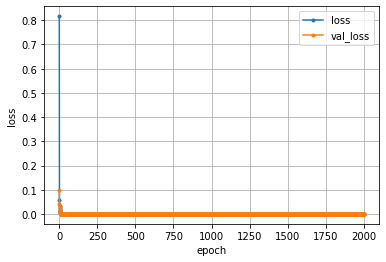

0.0008190894732251763


In [39]:
# 学習経過の可視化(大きさ)
loss     = history.history['loss']
val_loss = history.history['val_loss']

nb_epoch = len(loss)
plt.plot(range(nb_epoch), loss,     marker='.', label='loss')
plt.plot(range(nb_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
print(loss[-1])

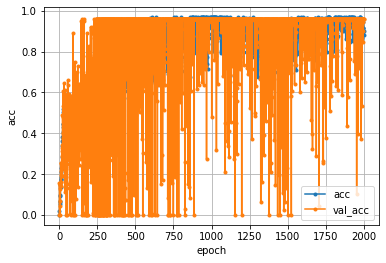

In [40]:
# 学習経過の可視化(大きさ)
acc     = history.history['acc']
val_acc = history.history['val_acc']

nb_epoch = len(acc)
plt.plot(range(nb_epoch), acc,     marker='.', label='acc')
plt.plot(range(nb_epoch), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [17]:
predict = model.predict([x_size_test, x_position_test])

In [18]:
print(predict[0]-y_test[0])

[-1.69108157e-02 -1.94768969e-02 -1.70367933e-02 -1.54423253e-02
 -1.28126909e-02 -1.13562796e-02 -5.55466292e-03 -1.79360582e-03
  6.20754213e-03  1.24530239e-02  1.72176573e-02  2.41643220e-02
  3.54102592e-02  3.85581459e-02  4.91921590e-02  5.67316662e-02
  6.22601273e-02  7.20209549e-02  7.79426271e-02  8.20923744e-02
  7.90735711e-02  6.12400753e-02 -5.79208136e-05  1.18210912e-04
 -1.73405558e-03  1.51365157e-03 -3.58205289e-04  1.65136353e-02
  1.33145083e-02  4.11977005e-04 -1.82264548e-02 -4.08559414e-02
 -6.40310887e-02 -9.81104323e-02 -1.22650070e-01 -1.47352075e-01
 -1.69745864e-01 -1.94717885e-01 -2.15330117e-01 -2.38647169e-01
 -2.56285287e-01 -2.71917708e-01 -2.91665247e-01 -3.09072147e-01
 -3.27455521e-01 -3.39527591e-01 -3.55546299e-01 -3.63783812e-01
 -3.71805181e-01 -3.74645918e-01]


In [19]:
print(predict[0])
print(y_test[0])

[ 2.6142862e+00  2.5901041e+00  2.5657072e+00  2.5065017e+00
  2.4275453e+00  2.3257067e+00  2.1661193e+00  2.0117724e+00
  1.9853365e+00  1.9020190e+00  1.7848597e+00  1.6470773e+00
  1.5174313e+00  1.2759151e+00  1.1016622e+00  8.5415167e-01
  1.9085713e-01 -3.3560205e-01 -4.3657237e-01 -1.0879086e+00
 -2.1366224e+00 -1.7604079e+00 -5.7920814e-05  1.1821091e-04
 -1.7340556e-03  1.5136516e-03 -3.5820529e-04 -2.4222844e+00
 -1.9664265e+00 -2.0050380e+00 -1.8130285e+00 -1.4203219e+00
 -1.4065261e+00 -1.9763194e+00 -2.1318281e+00 -2.2403641e+00
 -2.2975469e+00 -2.4036019e+00 -2.3749461e+00 -2.5072172e+00
 -2.5882733e+00 -2.5241177e+00 -2.6088552e+00 -2.8331141e+00
 -2.9317045e+00 -3.0467136e+00 -3.2727623e+00 -3.3717718e+00
 -3.4438832e+00 -3.4674959e+00]
[ 2.631197  2.609581  2.582744  2.521944  2.440358  2.337063  2.171674
  2.013566  1.979129  1.889566  1.767642  1.622913  1.482021  1.237357
  1.05247   0.79742   0.128597 -0.407623 -0.514515 -1.170001 -2.215696
 -1.821648  0.        0

In [4]:
#2つ目のモデル
# 入力を定義
size_input = Input(shape=(1,))
position_input = Input(shape=(2,))

# 入力1から結合前まで
x = Dense(1, activation="linear")(size_input)
x = Model(inputs=size_input, outputs=x)

# 入力2から結合前まで
y = Dense(1, activation="linear")(position_input)
y = Model(inputs=position_input, outputs=y)

# 結合
combined = concatenate([x.output, y.output])

# 密結合
z = Dense(64, activation="linear")(combined)
z = Dense(128, activation="tanh")(z)
z = Dense(256, activation="tanh")(z)
z = Dense(128, activation="tanh")(z)
z = Dense(50, activation="linear")(z)

# モデル定義とコンパイル
model2 = Model(inputs=[x.input, y.input], outputs=z)
model2.compile(loss='mse', optimizer='adam', metrics=['acc'])
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1)            2           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            3           input_2[0][0]                    
____________________________________________________________________________________________

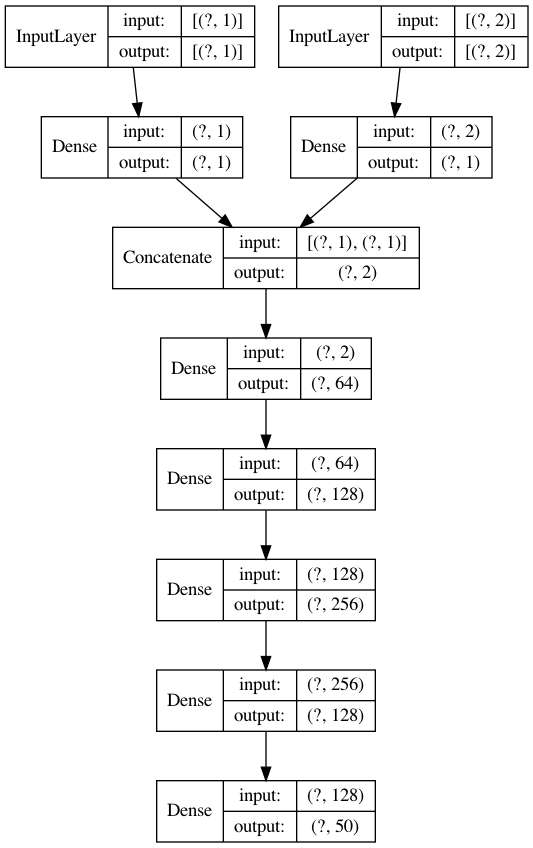

In [5]:
plot_model(model2, show_shapes=True, show_layer_names=False)

In [6]:
# 学習
epochs = 3000
batch_size = 128
history2 = model2.fit([x_size_train, x_position_train], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_size_test, x_position_test], y_test))

Epoch 1/3000
64/64 [==============================] - 0s 5ms/step - loss: 0.7099 - acc: 0.3811 - val_loss: 0.4126 - val_acc: 0.0770
Epoch 2/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.3812 - acc: 0.3929 - val_loss: 0.4025 - val_acc: 0.9497
Epoch 3/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.3672 - acc: 0.3982 - val_loss: 0.3811 - val_acc: 9.8668e-04
Epoch 4/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.3429 - acc: 0.4922 - val_loss: 0.3371 - val_acc: 0.7647
Epoch 5/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.3043 - acc: 0.6537 - val_loss: 0.3182 - val_acc: 0.7676
Epoch 6/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2849 - acc: 0.6730 - val_loss: 0.3049 - val_acc: 0.9107
Epoch 7/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2683 - acc: 0.6577 - val_loss: 0.2944 - val_acc: 0.7346
Epoch 8/3000
64/64 [==============================] - 0s 3ms/step - loss

64/64 [==============================] - 0s 3ms/step - loss: 0.2485 - acc: 0.8156 - val_loss: 0.2936 - val_acc: 0.9290
Epoch 124/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2528 - acc: 0.8954 - val_loss: 0.2827 - val_acc: 0.9304
Epoch 125/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2483 - acc: 0.8707 - val_loss: 0.2861 - val_acc: 0.8076
Epoch 126/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2461 - acc: 0.8864 - val_loss: 0.2766 - val_acc: 0.9270
Epoch 127/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2444 - acc: 0.9028 - val_loss: 0.2832 - val_acc: 0.9299
Epoch 128/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2473 - acc: 0.8816 - val_loss: 0.2867 - val_acc: 0.9285
Epoch 129/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2498 - acc: 0.8825 - val_loss: 0.2827 - val_acc: 0.9275
Epoch 130/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

64/64 [==============================] - 0s 3ms/step - loss: 0.2510 - acc: 0.9425 - val_loss: 0.2607 - val_acc: 0.9349
Epoch 246/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2226 - acc: 0.9412 - val_loss: 0.2567 - val_acc: 0.9373
Epoch 247/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2250 - acc: 0.9457 - val_loss: 0.2609 - val_acc: 0.9299
Epoch 248/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2213 - acc: 0.9407 - val_loss: 0.2521 - val_acc: 0.9359
Epoch 249/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2117 - acc: 0.9425 - val_loss: 0.2410 - val_acc: 0.9373
Epoch 250/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2143 - acc: 0.9473 - val_loss: 0.2455 - val_acc: 0.9393
Epoch 251/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2097 - acc: 0.9466 - val_loss: 0.2350 - val_acc: 0.9418
Epoch 252/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

64/64 [==============================] - 0s 3ms/step - loss: 0.0877 - acc: 0.9509 - val_loss: 0.0921 - val_acc: 0.9443
Epoch 368/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0816 - acc: 0.9504 - val_loss: 0.1032 - val_acc: 0.9413
Epoch 369/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0802 - acc: 0.9526 - val_loss: 0.0883 - val_acc: 0.9472
Epoch 370/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0859 - acc: 0.9551 - val_loss: 0.0891 - val_acc: 0.9477
Epoch 371/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0802 - acc: 0.9533 - val_loss: 0.0885 - val_acc: 0.9462
Epoch 372/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0886 - acc: 0.9539 - val_loss: 0.1021 - val_acc: 0.9433
Epoch 373/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1625 - acc: 0.9523 - val_loss: 0.1521 - val_acc: 0.9551
Epoch 374/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

64/64 [==============================] - 0s 3ms/step - loss: 0.1101 - acc: 0.9311 - val_loss: 0.1238 - val_acc: 0.9497
Epoch 490/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1030 - acc: 0.8168 - val_loss: 0.1153 - val_acc: 0.2708
Epoch 491/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1027 - acc: 0.8698 - val_loss: 0.1217 - val_acc: 0.9502
Epoch 492/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1057 - acc: 0.9414 - val_loss: 0.1132 - val_acc: 0.9418
Epoch 493/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2128 - acc: 0.7785 - val_loss: 0.2884 - val_acc: 0.9507
Epoch 494/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1932 - acc: 0.6466 - val_loss: 0.1656 - val_acc: 0.2037
Epoch 495/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1298 - acc: 0.7258 - val_loss: 0.1381 - val_acc: 0.9521
Epoch 496/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

64/64 [==============================] - 0s 3ms/step - loss: 0.1377 - acc: 0.9634 - val_loss: 0.1313 - val_acc: 0.9561
Epoch 612/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1078 - acc: 0.9653 - val_loss: 0.1315 - val_acc: 0.9586
Epoch 613/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1690 - acc: 0.9635 - val_loss: 0.3373 - val_acc: 0.9531
Epoch 614/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2140 - acc: 0.8762 - val_loss: 0.1556 - val_acc: 0.9452
Epoch 615/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1146 - acc: 0.9650 - val_loss: 0.1189 - val_acc: 0.9591
Epoch 616/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1143 - acc: 0.9673 - val_loss: 0.1247 - val_acc: 0.9536
Epoch 617/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1147 - acc: 0.9662 - val_loss: 0.1202 - val_acc: 0.9581
Epoch 618/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

64/64 [==============================] - 0s 3ms/step - loss: 0.1095 - acc: 0.9672 - val_loss: 0.1473 - val_acc: 0.9591
Epoch 734/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1496 - acc: 0.9666 - val_loss: 0.2823 - val_acc: 0.9556
Epoch 735/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1960 - acc: 0.9652 - val_loss: 0.1753 - val_acc: 0.9566
Epoch 736/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1474 - acc: 0.9666 - val_loss: 0.1622 - val_acc: 0.9615
Epoch 737/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1389 - acc: 0.9674 - val_loss: 0.1726 - val_acc: 0.9591
Epoch 738/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1256 - acc: 0.9661 - val_loss: 0.1319 - val_acc: 0.9566
Epoch 739/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1133 - acc: 0.9663 - val_loss: 0.1240 - val_acc: 0.9576
Epoch 740/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

64/64 [==============================] - 0s 3ms/step - loss: 0.1652 - acc: 0.9640 - val_loss: 0.1627 - val_acc: 0.9512
Epoch 856/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1174 - acc: 0.9655 - val_loss: 0.1242 - val_acc: 0.9561
Epoch 857/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1036 - acc: 0.9665 - val_loss: 0.1192 - val_acc: 0.9536
Epoch 858/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0931 - acc: 0.9662 - val_loss: 0.1042 - val_acc: 0.9566
Epoch 859/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0898 - acc: 0.9666 - val_loss: 0.0984 - val_acc: 0.9581
Epoch 860/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0966 - acc: 0.9660 - val_loss: 0.1304 - val_acc: 0.9586
Epoch 861/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0971 - acc: 0.9656 - val_loss: 0.1247 - val_acc: 0.9595
Epoch 862/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

64/64 [==============================] - 0s 3ms/step - loss: 0.1013 - acc: 0.9661 - val_loss: 0.1098 - val_acc: 0.9586
Epoch 978/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0927 - acc: 0.9663 - val_loss: 0.1077 - val_acc: 0.9595
Epoch 979/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0994 - acc: 0.9671 - val_loss: 0.1042 - val_acc: 0.9581
Epoch 980/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0920 - acc: 0.9669 - val_loss: 0.1077 - val_acc: 0.9556
Epoch 981/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0918 - acc: 0.9673 - val_loss: 0.0991 - val_acc: 0.9630
Epoch 982/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0932 - acc: 0.9677 - val_loss: 0.1779 - val_acc: 0.9561
Epoch 983/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1306 - acc: 0.9662 - val_loss: 0.1158 - val_acc: 0.9556
Epoch 984/3000
64/64 [==============================] - 0s 3ms/step - loss: 0

Epoch 1038/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0921 - acc: 0.9658 - val_loss: 0.1041 - val_acc: 0.9625
Epoch 1039/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0906 - acc: 0.9658 - val_loss: 0.1283 - val_acc: 0.9556
Epoch 1040/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1012 - acc: 0.9652 - val_loss: 0.1046 - val_acc: 0.9586
Epoch 1041/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0871 - acc: 0.9663 - val_loss: 0.1023 - val_acc: 0.9566
Epoch 1042/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0865 - acc: 0.9658 - val_loss: 0.0994 - val_acc: 0.9595
Epoch 1043/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0877 - acc: 0.9650 - val_loss: 0.0986 - val_acc: 0.9581
Epoch 1044/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0826 - acc: 0.9662 - val_loss: 0.0993 - val_acc: 0.9620
Epoch 1045/3000
64/64 [==============================] 

Epoch 1159/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0960 - acc: 0.9644 - val_loss: 0.1029 - val_acc: 0.9591
Epoch 1160/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0968 - acc: 0.9639 - val_loss: 0.1039 - val_acc: 0.9576
Epoch 1161/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0970 - acc: 0.9637 - val_loss: 0.1045 - val_acc: 0.9566
Epoch 1162/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0999 - acc: 0.9639 - val_loss: 0.1144 - val_acc: 0.9566
Epoch 1163/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1009 - acc: 0.9639 - val_loss: 0.1227 - val_acc: 0.9576
Epoch 1164/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1156 - acc: 0.9628 - val_loss: 0.1480 - val_acc: 0.9581
Epoch 1165/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1306 - acc: 0.9631 - val_loss: 0.1094 - val_acc: 0.9551
Epoch 1166/3000
64/64 [==============================] 

Epoch 1280/3000
64/64 [==============================] - 0s 4ms/step - loss: 0.0802 - acc: 0.9662 - val_loss: 0.1038 - val_acc: 0.9600
Epoch 1281/3000
64/64 [==============================] - 0s 4ms/step - loss: 0.0756 - acc: 0.9653 - val_loss: 0.0937 - val_acc: 0.9566
Epoch 1282/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0944 - acc: 0.9653 - val_loss: 0.1431 - val_acc: 0.9610
Epoch 1283/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0898 - acc: 0.9656 - val_loss: 0.0868 - val_acc: 0.9571
Epoch 1284/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0784 - acc: 0.9669 - val_loss: 0.0933 - val_acc: 0.9566
Epoch 1285/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0748 - acc: 0.9663 - val_loss: 0.0823 - val_acc: 0.9586
Epoch 1286/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0866 - acc: 0.9667 - val_loss: 0.0839 - val_acc: 0.9595
Epoch 1287/3000
64/64 [==============================] 

Epoch 1401/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0648 - acc: 0.9669 - val_loss: 0.0867 - val_acc: 0.9556
Epoch 1402/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0924 - acc: 0.9674 - val_loss: 0.1041 - val_acc: 0.9561
Epoch 1403/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0942 - acc: 0.9661 - val_loss: 0.0945 - val_acc: 0.9660
Epoch 1404/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0904 - acc: 0.9665 - val_loss: 0.1947 - val_acc: 0.9541
Epoch 1405/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1233 - acc: 0.9647 - val_loss: 0.0869 - val_acc: 0.9615
Epoch 1406/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0806 - acc: 0.9665 - val_loss: 0.0923 - val_acc: 0.9571
Epoch 1407/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0705 - acc: 0.9663 - val_loss: 0.0868 - val_acc: 0.9591
Epoch 1408/3000
64/64 [==============================] 

Epoch 1522/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1289 - acc: 0.9651 - val_loss: 0.1406 - val_acc: 0.9551
Epoch 1523/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0963 - acc: 0.9642 - val_loss: 0.0847 - val_acc: 0.9576
Epoch 1524/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0775 - acc: 0.9660 - val_loss: 0.2369 - val_acc: 0.9521
Epoch 1525/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1048 - acc: 0.9669 - val_loss: 0.0852 - val_acc: 0.9551
Epoch 1526/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0785 - acc: 0.9663 - val_loss: 0.0866 - val_acc: 0.9576
Epoch 1527/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0680 - acc: 0.9669 - val_loss: 0.0776 - val_acc: 0.9635
Epoch 1528/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0668 - acc: 0.9681 - val_loss: 0.0782 - val_acc: 0.9566
Epoch 1529/3000
64/64 [==============================] 

Epoch 1643/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0779 - acc: 0.9483 - val_loss: 0.0890 - val_acc: 0.9433
Epoch 1644/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0711 - acc: 0.9541 - val_loss: 0.0732 - val_acc: 0.9393
Epoch 1645/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0854 - acc: 0.9551 - val_loss: 0.0815 - val_acc: 0.9487
Epoch 1646/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0823 - acc: 0.9514 - val_loss: 0.0811 - val_acc: 0.9457
Epoch 1647/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0771 - acc: 0.9551 - val_loss: 0.1134 - val_acc: 0.9433
Epoch 1648/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1139 - acc: 0.9488 - val_loss: 0.2385 - val_acc: 0.9502
Epoch 1649/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1141 - acc: 0.9518 - val_loss: 0.0895 - val_acc: 0.9472
Epoch 1650/3000
64/64 [==============================] 

Epoch 1764/3000
64/64 [==============================] - 0s 4ms/step - loss: 0.0944 - acc: 0.9626 - val_loss: 0.0986 - val_acc: 0.9571
Epoch 1765/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0927 - acc: 0.9624 - val_loss: 0.1049 - val_acc: 0.9576
Epoch 1766/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0881 - acc: 0.9648 - val_loss: 0.1014 - val_acc: 0.9576
Epoch 1767/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0891 - acc: 0.9634 - val_loss: 0.0974 - val_acc: 0.9551
Epoch 1768/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0931 - acc: 0.9620 - val_loss: 0.1251 - val_acc: 0.9571
Epoch 1769/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0967 - acc: 0.9642 - val_loss: 0.0992 - val_acc: 0.9581
Epoch 1770/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1044 - acc: 0.9639 - val_loss: 0.1013 - val_acc: 0.9576
Epoch 1771/3000
64/64 [==============================] 

Epoch 1885/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1134 - acc: 0.9639 - val_loss: 0.1045 - val_acc: 0.9551
Epoch 1886/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0944 - acc: 0.9661 - val_loss: 0.0859 - val_acc: 0.9576
Epoch 1887/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0837 - acc: 0.9658 - val_loss: 0.0912 - val_acc: 0.9526
Epoch 1888/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0778 - acc: 0.9657 - val_loss: 0.0926 - val_acc: 0.9561
Epoch 1889/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0776 - acc: 0.9650 - val_loss: 0.0816 - val_acc: 0.9556
Epoch 1890/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0774 - acc: 0.9666 - val_loss: 0.0848 - val_acc: 0.9571
Epoch 1891/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0745 - acc: 0.9657 - val_loss: 0.0788 - val_acc: 0.9556
Epoch 1892/3000
64/64 [==============================] 

Epoch 2006/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1491 - acc: 0.9665 - val_loss: 0.1493 - val_acc: 0.9595
Epoch 2007/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1237 - acc: 0.9634 - val_loss: 0.1535 - val_acc: 0.9521
Epoch 2008/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1196 - acc: 0.9583 - val_loss: 0.1882 - val_acc: 0.9472
Epoch 2009/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1287 - acc: 0.9584 - val_loss: 0.1118 - val_acc: 0.9477
Epoch 2010/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1135 - acc: 0.9561 - val_loss: 0.1622 - val_acc: 0.9487
Epoch 2011/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1166 - acc: 0.9573 - val_loss: 0.1111 - val_acc: 0.9551
Epoch 2012/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0991 - acc: 0.9663 - val_loss: 0.0975 - val_acc: 0.9571
Epoch 2013/3000
64/64 [==============================] 

Epoch 2127/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0893 - acc: 0.9681 - val_loss: 0.0874 - val_acc: 0.9595
Epoch 2128/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0982 - acc: 0.9676 - val_loss: 0.0830 - val_acc: 0.9630
Epoch 2129/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0804 - acc: 0.9684 - val_loss: 0.0877 - val_acc: 0.9571
Epoch 2130/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0741 - acc: 0.9699 - val_loss: 0.0861 - val_acc: 0.9610
Epoch 2131/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0721 - acc: 0.9687 - val_loss: 0.0814 - val_acc: 0.9655
Epoch 2132/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2961 - acc: 0.9656 - val_loss: 0.3121 - val_acc: 0.9595
Epoch 2133/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.2356 - acc: 0.9663 - val_loss: 0.2720 - val_acc: 0.9591
Epoch 2134/3000
64/64 [==============================] 

Epoch 2248/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1107 - acc: 0.9672 - val_loss: 0.1237 - val_acc: 0.9640
Epoch 2249/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1064 - acc: 0.9689 - val_loss: 0.1205 - val_acc: 0.9610
Epoch 2250/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1087 - acc: 0.9677 - val_loss: 0.1230 - val_acc: 0.9615
Epoch 2251/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1139 - acc: 0.9684 - val_loss: 0.1533 - val_acc: 0.9605
Epoch 2252/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1137 - acc: 0.9683 - val_loss: 0.1177 - val_acc: 0.9595
Epoch 2253/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1059 - acc: 0.9677 - val_loss: 0.1156 - val_acc: 0.9610
Epoch 2254/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1114 - acc: 0.9684 - val_loss: 0.1257 - val_acc: 0.9595
Epoch 2255/3000
64/64 [==============================] 

Epoch 2369/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1037 - acc: 0.9681 - val_loss: 0.1166 - val_acc: 0.9581
Epoch 2370/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1018 - acc: 0.9687 - val_loss: 0.1102 - val_acc: 0.9605
Epoch 2371/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1017 - acc: 0.9683 - val_loss: 0.1535 - val_acc: 0.9605
Epoch 2372/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1194 - acc: 0.9674 - val_loss: 0.1399 - val_acc: 0.9605
Epoch 2373/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1299 - acc: 0.9688 - val_loss: 0.1320 - val_acc: 0.9600
Epoch 2374/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1237 - acc: 0.9689 - val_loss: 0.1977 - val_acc: 0.9600
Epoch 2375/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1396 - acc: 0.9667 - val_loss: 0.1346 - val_acc: 0.9615
Epoch 2376/3000
64/64 [==============================] 

Epoch 2490/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0868 - acc: 0.9672 - val_loss: 0.1097 - val_acc: 0.9576
Epoch 2491/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0863 - acc: 0.9668 - val_loss: 0.1299 - val_acc: 0.9566
Epoch 2492/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0911 - acc: 0.9666 - val_loss: 0.1190 - val_acc: 0.9566
Epoch 2493/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0926 - acc: 0.9660 - val_loss: 0.1069 - val_acc: 0.9556
Epoch 2494/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0901 - acc: 0.9677 - val_loss: 0.1116 - val_acc: 0.9546
Epoch 2495/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0914 - acc: 0.9662 - val_loss: 0.0997 - val_acc: 0.9556
Epoch 2496/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0810 - acc: 0.9667 - val_loss: 0.0941 - val_acc: 0.9541
Epoch 2497/3000
64/64 [==============================] 

Epoch 2611/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0843 - acc: 0.9666 - val_loss: 0.0934 - val_acc: 0.9556
Epoch 2612/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0870 - acc: 0.9657 - val_loss: 0.0929 - val_acc: 0.9615
Epoch 2613/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0835 - acc: 0.9661 - val_loss: 0.0921 - val_acc: 0.9546
Epoch 2614/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0807 - acc: 0.9660 - val_loss: 0.1009 - val_acc: 0.9561
Epoch 2615/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0813 - acc: 0.9653 - val_loss: 0.0979 - val_acc: 0.9546
Epoch 2616/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0832 - acc: 0.9655 - val_loss: 0.0872 - val_acc: 0.9556
Epoch 2617/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.0839 - acc: 0.9660 - val_loss: 0.1070 - val_acc: 0.9566
Epoch 2618/3000
64/64 [==============================] 

Epoch 2732/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1464 - acc: 0.9657 - val_loss: 0.1575 - val_acc: 0.9551
Epoch 2733/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1345 - acc: 0.9663 - val_loss: 0.1375 - val_acc: 0.9576
Epoch 2734/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1331 - acc: 0.9668 - val_loss: 0.1381 - val_acc: 0.9561
Epoch 2735/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1409 - acc: 0.9663 - val_loss: 0.1504 - val_acc: 0.9581
Epoch 2736/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1345 - acc: 0.9665 - val_loss: 0.1503 - val_acc: 0.9581
Epoch 2737/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1410 - acc: 0.9665 - val_loss: 0.1458 - val_acc: 0.9581
Epoch 2738/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1407 - acc: 0.9662 - val_loss: 0.1421 - val_acc: 0.9566
Epoch 2739/3000
64/64 [==============================] 

Epoch 2853/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1234 - acc: 0.9671 - val_loss: 0.1364 - val_acc: 0.9595
Epoch 2854/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1180 - acc: 0.9673 - val_loss: 0.1393 - val_acc: 0.9586
Epoch 2855/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1243 - acc: 0.9677 - val_loss: 0.1274 - val_acc: 0.9600
Epoch 2856/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1221 - acc: 0.9668 - val_loss: 0.1354 - val_acc: 0.9620
Epoch 2857/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1222 - acc: 0.9673 - val_loss: 0.1290 - val_acc: 0.9605
Epoch 2858/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1273 - acc: 0.9671 - val_loss: 0.1283 - val_acc: 0.9605
Epoch 2859/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1194 - acc: 0.9665 - val_loss: 0.1250 - val_acc: 0.9595
Epoch 2860/3000
64/64 [==============================] 

Epoch 2974/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1094 - acc: 0.9665 - val_loss: 0.1235 - val_acc: 0.9595
Epoch 2975/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1036 - acc: 0.9678 - val_loss: 0.1214 - val_acc: 0.9640
Epoch 2976/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1057 - acc: 0.9671 - val_loss: 0.1231 - val_acc: 0.9586
Epoch 2977/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1047 - acc: 0.9677 - val_loss: 0.1309 - val_acc: 0.9620
Epoch 2978/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1140 - acc: 0.9665 - val_loss: 0.1246 - val_acc: 0.9605
Epoch 2979/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1136 - acc: 0.9674 - val_loss: 0.1169 - val_acc: 0.9576
Epoch 2980/3000
64/64 [==============================] - 0s 3ms/step - loss: 0.1214 - acc: 0.9666 - val_loss: 0.1337 - val_acc: 0.9556
Epoch 2981/3000
64/64 [==============================] 

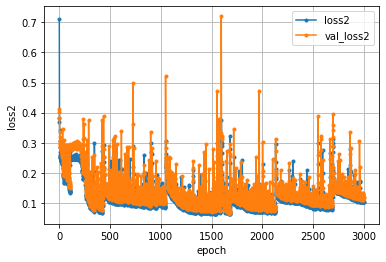

In [7]:
# 学習経過の可視化(大きさ)
loss2     = history2.history['loss']
val_loss2 = history2.history['val_loss']

nb_epoch = len(loss2)
plt.plot(range(nb_epoch), loss2,     marker='.', label='loss2')
plt.plot(range(nb_epoch), val_loss2, marker='.', label='val_loss2')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss2')
plt.show()

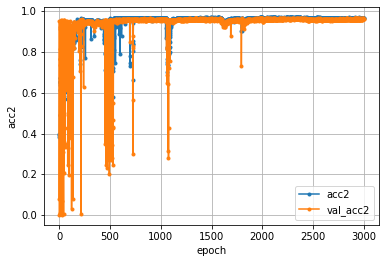

In [8]:
# 学習経過の可視化(大きさ)
acc2     = history2.history['acc']
val_acc2 = history2.history['val_acc']

nb_epoch = len(acc2)
plt.plot(range(nb_epoch), acc2,     marker='.', label='acc2')
plt.plot(range(nb_epoch), val_acc2, marker='.', label='val_acc2')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc2')
plt.show()

In [9]:
predict2 = model2.predict([x_size_test, x_position_test])
print(x_position_test[0])
print(predict2[0]-y_test[0])
print(x_position_test[1])
print(predict2[1]-y_test[1])

[[38.5]
 [21.5]]
[-2.00298672e-03 -1.59025943e-03  5.86756699e-04  4.11689995e-03
  8.06191124e-03  1.15077754e-02  1.51614285e-02  1.90208758e-02
  2.27203472e-02  2.34877815e-02  2.42906497e-02  2.81130866e-02
  3.30420722e-02  3.62808760e-02  4.00873476e-02  4.32681874e-02
  4.52947211e-02  4.72288181e-02  5.37033399e-02  6.45259917e-02
  7.45966885e-02  4.54866960e-02 -1.45515427e-04  4.83118417e-03
  1.11624599e-04  5.07462770e-04 -3.92738730e-04  1.63584904e-02
 -1.96245436e-02 -6.83684958e-02 -1.02957894e-01 -1.35525678e-01
 -1.68293104e-01 -2.02044201e-01 -2.23329589e-01 -2.40371380e-01
 -2.53583197e-01 -2.67964845e-01 -2.80327355e-01 -2.95938626e-01
 -3.09527650e-01 -3.18972551e-01 -3.29614150e-01 -3.39622904e-01
 -3.46871087e-01 -3.52721579e-01 -3.58077484e-01 -3.60928043e-01
 -3.62852171e-01 -3.63464210e-01]
[[ 3.]
 [12.]]
[-2.21530764e-01 -2.20360201e-01 -2.14895675e-01 -2.06055331e-01
 -1.94630895e-01 -1.81722600e-01 -1.68042953e-01 -1.51705440e-01
 -1.30755538e-01 -1.1372

In [10]:
print(predict2[0])
print(y_test[0])

[ 2.6469550e+00  2.6257567e+00  2.6011198e+00  2.5438869e+00
  2.4662969e+00  2.3665128e+00  2.2048454e+00  2.0506809e+00
  2.0200593e+00  1.9313698e+00  1.8103456e+00  1.6695161e+00
  1.5336031e+00  1.2921839e+00  1.1110533e+00  8.5903919e-01
  1.9202572e-01 -3.4265518e-01 -4.4386366e-01 -1.0896480e+00
 -2.1269853e+00 -1.7662003e+00 -1.4551543e-04  4.8311842e-03
  1.1162460e-04  5.0746277e-04 -3.9273873e-04 -2.4062395e+00
 -1.9760855e+00 -2.0456605e+00 -1.8664949e+00 -1.4818727e+00
 -1.4764111e+00 -2.0455482e+00 -2.1987486e+00 -2.3015094e+00
 -2.3523922e+00 -2.4518518e+00 -2.4192224e+00 -2.5493376e+00
 -2.6323617e+00 -2.5672956e+00 -2.6494431e+00 -2.8745079e+00
 -2.9687791e+00 -3.0841346e+00 -3.3071685e+00 -3.4057550e+00
 -3.4750562e+00 -3.4975562e+00]
[ 2.648958  2.627347  2.600533  2.53977   2.458235  2.355005  2.189684
  2.03166   1.997339  1.907882  1.786055  1.641403  1.500561  1.255903
  1.070966  0.815771  0.146731 -0.389884 -0.497567 -1.154174 -2.201582
 -1.811687  0.        0

In [41]:
#2つ目のモデル
# 入力を定義
size_input = Input(shape=(1,))
position_input = Input(shape=(2,))

# 入力1から結合前まで
x = Dense(1, activation="linear")(size_input)
x = Model(inputs=size_input, outputs=x)

# 入力2から結合前まで
y = Dense(1, activation="linear")(position_input)
y = Model(inputs=position_input, outputs=y)

# 結合
combined = concatenate([x.output, y.output])

# 密結合
z = Dense(64, activation="linear")(combined)
z = Dense(128, activation="tanh")(z)
z = Dense(256, activation="tanh")(z)
z = Dense(128, activation="tanh")(z)
z = Dense(64, activation="tanh")(z)
z = Dense(50, activation="linear")(z)

# モデル定義とコンパイル
model3 = Model(inputs=[x.input, y.input], outputs=z)
model3.compile(loss='mse', optimizer='adam', metrics=['acc'])
model3.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 1)            2           input_7[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1)            3           input_8[0][0]                    
___________________________________________________________________________________________

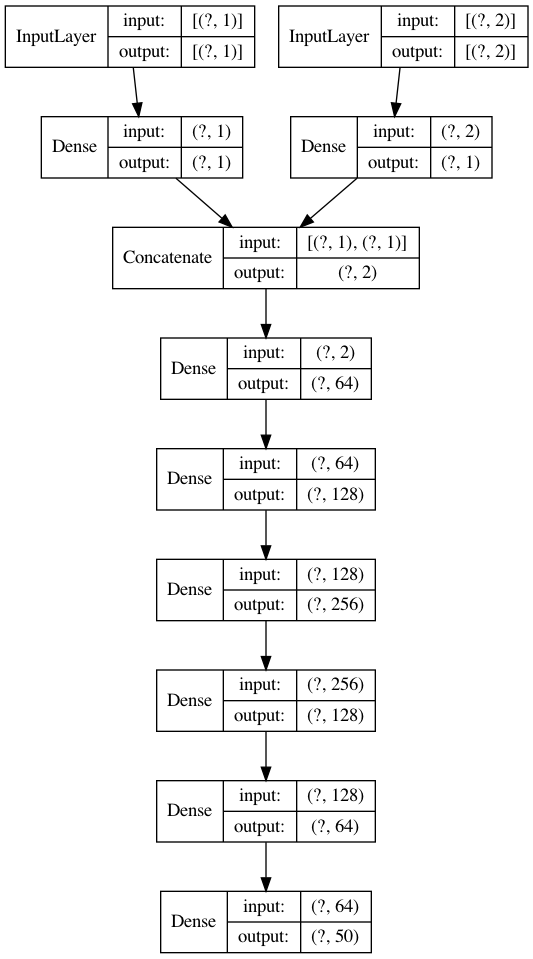

In [42]:
plot_model(model3, show_shapes=True, show_layer_names=False)

In [43]:
# 学習
epochs = 2000
batch_size = 128
history3 = model3.fit([x_size_train, x_position_train], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_size_test, x_position_test], y_test))

Epoch 1/2000
64/64 [==============================] - 0s 5ms/step - loss: 0.0457 - acc: 0.0651 - val_loss: 9.8722e-04 - val_acc: 0.0261
Epoch 2/2000
64/64 [==============================] - 0s 4ms/step - loss: 9.2946e-04 - acc: 0.1725 - val_loss: 8.4570e-04 - val_acc: 0.0715
Epoch 3/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.8785e-04 - acc: 0.2236 - val_loss: 8.4641e-04 - val_acc: 0.7361
Epoch 4/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.8956e-04 - acc: 0.3053 - val_loss: 8.2322e-04 - val_acc: 0.8747
Epoch 5/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.6449e-04 - acc: 0.3180 - val_loss: 8.1761e-04 - val_acc: 0.0424
Epoch 6/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.6084e-04 - acc: 0.3371 - val_loss: 8.0572e-04 - val_acc: 0.0760
Epoch 7/2000
64/64 [==============================] - 0s 4ms/step - loss: 8.3958e-04 - acc: 0.3210 - val_loss: 8.5284e-04 - val_acc: 9.8668e-04
Epoch 8/2000
64/64 [

Epoch 59/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.1976e-04 - acc: 0.3619 - val_loss: 6.9254e-04 - val_acc: 0.0069
Epoch 60/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.3107e-04 - acc: 0.3838 - val_loss: 7.2310e-04 - val_acc: 0.9250
Epoch 61/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.3325e-04 - acc: 0.3666 - val_loss: 8.0371e-04 - val_acc: 0.0079
Epoch 62/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.0949e-04 - acc: 0.3647 - val_loss: 8.5583e-04 - val_acc: 0.8313
Epoch 63/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.0545e-04 - acc: 0.3668 - val_loss: 6.9531e-04 - val_acc: 0.0992
Epoch 64/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.2796e-04 - acc: 0.3323 - val_loss: 7.1324e-04 - val_acc: 0.9551
Epoch 65/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.2130e-04 - acc: 0.3545 - val_loss: 7.0591e-04 - val_acc: 0.0049
Epoch 66/2000

Epoch 117/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.4444e-04 - acc: 0.5036 - val_loss: 5.5796e-04 - val_acc: 0.0020
Epoch 118/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.6887e-04 - acc: 0.3912 - val_loss: 6.1872e-04 - val_acc: 0.0143
Epoch 119/2000
64/64 [==============================] - 0s 5ms/step - loss: 5.7798e-04 - acc: 0.4737 - val_loss: 6.3349e-04 - val_acc: 0.8752
Epoch 120/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.2834e-04 - acc: 0.5322 - val_loss: 6.4249e-04 - val_acc: 0.5570
Epoch 121/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.3015e-04 - acc: 0.4700 - val_loss: 8.1182e-04 - val_acc: 0.7444
Epoch 122/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.4752e-04 - acc: 0.4086 - val_loss: 6.8579e-04 - val_acc: 0.7390
Epoch 123/2000
64/64 [==============================] - 0s 4ms/step - loss: 6.1272e-04 - acc: 0.4315 - val_loss: 6.6335e-04 - val_acc: 0.9512
Epoch 

64/64 [==============================] - 0s 4ms/step - loss: 4.0339e-04 - acc: 0.5316 - val_loss: 4.6178e-04 - val_acc: 0.7617
Epoch 175/2000
64/64 [==============================] - 0s 4ms/step - loss: 4.7971e-04 - acc: 0.5342 - val_loss: 5.0608e-04 - val_acc: 0.3902
Epoch 176/2000
64/64 [==============================] - 0s 4ms/step - loss: 5.4760e-04 - acc: 0.5760 - val_loss: 6.6844e-04 - val_acc: 0.8328
Epoch 177/2000
64/64 [==============================] - 0s 4ms/step - loss: 4.1951e-04 - acc: 0.5583 - val_loss: 4.0353e-04 - val_acc: 0.0661
Epoch 178/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7226e-04 - acc: 0.5844 - val_loss: 4.3451e-04 - val_acc: 0.2042
Epoch 179/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.1863e-04 - acc: 0.5640 - val_loss: 4.1355e-04 - val_acc: 0.1075
Epoch 180/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.4289e-04 - acc: 0.6136 - val_loss: 4.4008e-04 - val_acc: 0.9344
Epoch 181/2000
64/64 

Epoch 232/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.2257e-04 - acc: 0.6232 - val_loss: 3.1651e-04 - val_acc: 0.0587
Epoch 233/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.8684e-04 - acc: 0.5983 - val_loss: 3.1022e-04 - val_acc: 0.5624
Epoch 234/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.0853e-04 - acc: 0.6629 - val_loss: 3.1768e-04 - val_acc: 0.2684
Epoch 235/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.4107e-04 - acc: 0.5391 - val_loss: 3.7541e-04 - val_acc: 0.5116
Epoch 236/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9863e-04 - acc: 0.6649 - val_loss: 4.7071e-04 - val_acc: 0.9502
Epoch 237/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.5651e-04 - acc: 0.4875 - val_loss: 5.4009e-04 - val_acc: 0.9275
Epoch 238/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.6274e-04 - acc: 0.5264 - val_loss: 4.6183e-04 - val_acc: 0.8426
Epoch 

Epoch 290/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.4302e-04 - acc: 0.6341 - val_loss: 4.0156e-04 - val_acc: 0.7681
Epoch 291/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.6221e-04 - acc: 0.4890 - val_loss: 2.6260e-04 - val_acc: 0.8130
Epoch 292/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.9228e-04 - acc: 0.5178 - val_loss: 2.7991e-04 - val_acc: 0.2131
Epoch 293/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9150e-04 - acc: 0.4642 - val_loss: 2.6108e-04 - val_acc: 0.9447
Epoch 294/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5058e-04 - acc: 0.5871 - val_loss: 3.0371e-04 - val_acc: 0.0128
Epoch 295/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5506e-04 - acc: 0.6117 - val_loss: 2.7328e-04 - val_acc: 0.9457
Epoch 296/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.7063e-04 - acc: 0.6257 - val_loss: 2.7315e-04 - val_acc: 0.8170
Epoch 

Epoch 348/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2066e-04 - acc: 0.6385 - val_loss: 2.2540e-04 - val_acc: 0.8189
Epoch 349/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.1906e-04 - acc: 0.7366 - val_loss: 2.2895e-04 - val_acc: 0.9487
Epoch 350/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2992e-04 - acc: 0.6592 - val_loss: 3.4107e-04 - val_acc: 0.9211
Epoch 351/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.0842e-04 - acc: 0.5493 - val_loss: 2.6328e-04 - val_acc: 0.8263
Epoch 352/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.3432e-04 - acc: 0.6421 - val_loss: 2.4185e-04 - val_acc: 0.1924
Epoch 353/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5751e-04 - acc: 0.6283 - val_loss: 2.7640e-04 - val_acc: 0.0385
Epoch 354/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.1960e-04 - acc: 0.6217 - val_loss: 2.2344e-04 - val_acc: 0.4090
Epoch 

Epoch 406/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.0479e-04 - acc: 0.6230 - val_loss: 2.6205e-04 - val_acc: 0.0622
Epoch 407/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.9073e-04 - acc: 0.5983 - val_loss: 5.1476e-04 - val_acc: 0.3226
Epoch 408/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2480e-04 - acc: 0.5816 - val_loss: 2.1418e-04 - val_acc: 0.5555
Epoch 409/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.8757e-04 - acc: 0.7010 - val_loss: 2.2212e-04 - val_acc: 0.0128
Epoch 410/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.1586e-04 - acc: 0.6994 - val_loss: 2.1958e-04 - val_acc: 0.9038
Epoch 411/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.8987e-04 - acc: 0.7035 - val_loss: 1.9431e-04 - val_acc: 0.3897
Epoch 412/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.8278e-04 - acc: 0.6961 - val_loss: 1.8142e-04 - val_acc: 0.9447
Epoch 

Epoch 464/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.4516e-04 - acc: 0.5792 - val_loss: 3.0614e-04 - val_acc: 0.9502
Epoch 465/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.0087e-04 - acc: 0.6198 - val_loss: 2.1719e-04 - val_acc: 0.7903
Epoch 466/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5263e-04 - acc: 0.7378 - val_loss: 2.4035e-04 - val_acc: 0.9393
Epoch 467/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.4001e-04 - acc: 0.6989 - val_loss: 3.3906e-04 - val_acc: 0.0340
Epoch 468/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.1049e-04 - acc: 0.6569 - val_loss: 1.8092e-04 - val_acc: 0.8989
Epoch 469/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.5978e-04 - acc: 0.8004 - val_loss: 1.9817e-04 - val_acc: 0.9334
Epoch 470/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.6400e-04 - acc: 0.7794 - val_loss: 1.9659e-04 - val_acc: 0.9053
Epoch 

Epoch 522/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.6027e-04 - acc: 0.7916 - val_loss: 4.5753e-04 - val_acc: 0.9457
Epoch 523/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.7670e-04 - acc: 0.5324 - val_loss: 2.3019e-04 - val_acc: 0.9285
Epoch 524/2000
64/64 [==============================] - 0s 4ms/step - loss: 2.4538e-04 - acc: 0.5220 - val_loss: 1.8888e-04 - val_acc: 0.8194
Epoch 525/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.8950e-04 - acc: 0.6997 - val_loss: 1.6693e-04 - val_acc: 0.9117
Epoch 526/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.6573e-04 - acc: 0.6531 - val_loss: 2.0363e-04 - val_acc: 0.9398
Epoch 527/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.1944e-04 - acc: 0.6581 - val_loss: 2.4338e-04 - val_acc: 0.9260
Epoch 528/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.7193e-04 - acc: 0.5657 - val_loss: 1.9128e-04 - val_acc: 0.9304
Epoch 

Epoch 580/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.5964e-04 - acc: 0.7821 - val_loss: 1.6798e-04 - val_acc: 0.9043
Epoch 581/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.3117e-04 - acc: 0.7033 - val_loss: 2.4700e-04 - val_acc: 0.8846
Epoch 582/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2851e-04 - acc: 0.7525 - val_loss: 2.6881e-04 - val_acc: 0.6280
Epoch 583/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.3664e-04 - acc: 0.6978 - val_loss: 2.3051e-04 - val_acc: 0.8101
Epoch 584/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2467e-04 - acc: 0.5662 - val_loss: 2.2910e-04 - val_acc: 0.9324
Epoch 585/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.8896e-04 - acc: 0.7234 - val_loss: 1.9394e-04 - val_acc: 0.9275
Epoch 586/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.9094e-04 - acc: 0.7184 - val_loss: 1.6202e-04 - val_acc: 0.5180
Epoch 

Epoch 638/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.4175e-04 - acc: 0.6767 - val_loss: 1.4173e-04 - val_acc: 0.7676
Epoch 639/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.0611e-04 - acc: 0.7987 - val_loss: 2.3153e-04 - val_acc: 0.8017
Epoch 640/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.0938e-04 - acc: 0.6569 - val_loss: 2.2769e-04 - val_acc: 0.6532
Epoch 641/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2351e-04 - acc: 0.5808 - val_loss: 2.2250e-04 - val_acc: 0.8111
Epoch 642/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.7680e-04 - acc: 0.6299 - val_loss: 1.6939e-04 - val_acc: 0.1993
Epoch 643/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.8613e-04 - acc: 0.6093 - val_loss: 1.8240e-04 - val_acc: 0.9235
Epoch 644/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.4854e-04 - acc: 0.5913 - val_loss: 1.7095e-04 - val_acc: 0.9299
Epoch 

Epoch 696/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.4132e-04 - acc: 0.7956 - val_loss: 1.5363e-04 - val_acc: 0.9285
Epoch 697/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.5683e-04 - acc: 0.7058 - val_loss: 1.6459e-04 - val_acc: 0.8012
Epoch 698/2000
64/64 [==============================] - 0s 4ms/step - loss: 2.1338e-04 - acc: 0.6331 - val_loss: 1.8798e-04 - val_acc: 0.2906
Epoch 699/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.6258e-04 - acc: 0.7153 - val_loss: 1.6754e-04 - val_acc: 0.9359
Epoch 700/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.5284e-04 - acc: 0.7288 - val_loss: 1.5335e-04 - val_acc: 0.8155
Epoch 701/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.4751e-04 - acc: 0.7560 - val_loss: 1.5268e-04 - val_acc: 0.4213
Epoch 702/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.4231e-04 - acc: 0.6637 - val_loss: 2.5504e-04 - val_acc: 0.7874
Epoch 

64/64 [==============================] - 0s 4ms/step - loss: 1.7796e-04 - acc: 0.7012 - val_loss: 2.0446e-04 - val_acc: 0.7070
Epoch 754/2000
64/64 [==============================] - 0s 4ms/step - loss: 1.7618e-04 - acc: 0.7416 - val_loss: 4.5647e-04 - val_acc: 0.7385
Epoch 755/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2038e-04 - acc: 0.7095 - val_loss: 1.9732e-04 - val_acc: 0.8007
Epoch 756/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.5016e-04 - acc: 0.8192 - val_loss: 1.5899e-04 - val_acc: 0.9383
Epoch 757/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.3606e-04 - acc: 0.7990 - val_loss: 1.5722e-04 - val_acc: 0.5851
Epoch 758/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.3703e-04 - acc: 0.7341 - val_loss: 1.8058e-04 - val_acc: 0.9438
Epoch 759/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2205e-04 - acc: 0.7428 - val_loss: 3.0583e-04 - val_acc: 0.6611
Epoch 760/2000
64/64 

Epoch 811/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.2912e-04 - acc: 0.7981 - val_loss: 1.5153e-04 - val_acc: 0.9433
Epoch 812/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.3837e-04 - acc: 0.8001 - val_loss: 3.6588e-04 - val_acc: 0.9117
Epoch 813/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8928e-04 - acc: 0.6891 - val_loss: 4.4117e-04 - val_acc: 0.9378
Epoch 814/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.6916e-04 - acc: 0.6565 - val_loss: 1.8664e-04 - val_acc: 0.4430
Epoch 815/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.7878e-04 - acc: 0.5990 - val_loss: 2.0974e-04 - val_acc: 0.1273
Epoch 816/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.4693e-04 - acc: 0.6943 - val_loss: 1.7171e-04 - val_acc: 0.9299
Epoch 817/2000
64/64 [==============================] - 0s 3ms/step - loss: 1.5724e-04 - acc: 0.6734 - val_loss: 2.0472e-04 - val_acc: 0.9467
Epoch 

Epoch 869/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5140e-04 - acc: 0.5326 - val_loss: 2.7456e-04 - val_acc: 0.0671
Epoch 870/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.1315e-04 - acc: 0.5810 - val_loss: 4.1998e-04 - val_acc: 0.1253
Epoch 871/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8318e-04 - acc: 0.5112 - val_loss: 2.5869e-04 - val_acc: 0.2171
Epoch 872/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.9791e-04 - acc: 0.6179 - val_loss: 3.8482e-04 - val_acc: 0.9526
Epoch 873/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5813e-04 - acc: 0.7052 - val_loss: 2.8480e-04 - val_acc: 0.9482
Epoch 874/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.2867e-04 - acc: 0.7416 - val_loss: 2.6760e-04 - val_acc: 0.9393
Epoch 875/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.4765e-04 - acc: 0.6360 - val_loss: 6.0025e-04 - val_acc: 0.9354
Epoch 

Epoch 927/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.3600e-04 - acc: 0.7467 - val_loss: 5.2873e-04 - val_acc: 0.4943
Epoch 928/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.2276e-04 - acc: 0.6930 - val_loss: 6.7778e-04 - val_acc: 0.5481
Epoch 929/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.6446e-04 - acc: 0.5897 - val_loss: 6.5210e-04 - val_acc: 0.7588
Epoch 930/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.0365e-04 - acc: 0.6573 - val_loss: 3.7000e-04 - val_acc: 0.8209
Epoch 931/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8555e-04 - acc: 0.7900 - val_loss: 3.8128e-04 - val_acc: 0.9546
Epoch 932/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7531e-04 - acc: 0.6499 - val_loss: 3.5662e-04 - val_acc: 0.9605
Epoch 933/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.4675e-04 - acc: 0.6270 - val_loss: 3.5582e-04 - val_acc: 0.0163
Epoch 

Epoch 985/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.1053e-04 - acc: 0.7406 - val_loss: 4.1226e-04 - val_acc: 0.4963
Epoch 986/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.0204e-04 - acc: 0.5977 - val_loss: 3.4884e-04 - val_acc: 0.9521
Epoch 987/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.0984e-04 - acc: 0.7778 - val_loss: 2.8862e-04 - val_acc: 0.0459
Epoch 988/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.9174e-04 - acc: 0.7091 - val_loss: 3.0469e-04 - val_acc: 0.9541
Epoch 989/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.7604e-04 - acc: 0.6543 - val_loss: 8.2828e-04 - val_acc: 0.0237
Epoch 990/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9844e-04 - acc: 0.6166 - val_loss: 2.9729e-04 - val_acc: 0.8416
Epoch 991/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.8527e-04 - acc: 0.7621 - val_loss: 2.9802e-04 - val_acc: 0.9517
Epoch 

64/64 [==============================] - 0s 4ms/step - loss: 2.3807e-04 - acc: 0.7279 - val_loss: 2.7991e-04 - val_acc: 0.9556
Epoch 1043/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.4184e-04 - acc: 0.8404 - val_loss: 2.8367e-04 - val_acc: 0.0237
Epoch 1044/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.6114e-04 - acc: 0.6574 - val_loss: 6.3986e-04 - val_acc: 0.9600
Epoch 1045/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.0235e-04 - acc: 0.5249 - val_loss: 3.8281e-04 - val_acc: 0.8801
Epoch 1046/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.2861e-04 - acc: 0.5645 - val_loss: 3.0571e-04 - val_acc: 0.9620
Epoch 1047/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.9794e-04 - acc: 0.6182 - val_loss: 9.2377e-04 - val_acc: 0.9581
Epoch 1048/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.1343e-04 - acc: 0.4463 - val_loss: 2.7170e-04 - val_acc: 0.9571
Epoch 1049/2000

64/64 [==============================] - 0s 3ms/step - loss: 5.6667e-04 - acc: 0.6686 - val_loss: 5.3103e-04 - val_acc: 0.0567
Epoch 1100/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.1450e-04 - acc: 0.6924 - val_loss: 6.4720e-04 - val_acc: 0.8392
Epoch 1101/2000
64/64 [==============================] - 0s 4ms/step - loss: 5.3447e-04 - acc: 0.8355 - val_loss: 5.5830e-04 - val_acc: 0.9576
Epoch 1102/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.3668e-04 - acc: 0.7276 - val_loss: 7.1252e-04 - val_acc: 0.9605
Epoch 1103/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.8256e-04 - acc: 0.6677 - val_loss: 6.8009e-04 - val_acc: 4.9334e-04
Epoch 1104/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.1695e-04 - acc: 0.7596 - val_loss: 6.1328e-04 - val_acc: 0.9023
Epoch 1105/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.0802e-04 - acc: 0.7437 - val_loss: 6.3243e-04 - val_acc: 0.9576
Epoch 1106/

64/64 [==============================] - 0s 3ms/step - loss: 3.6822e-04 - acc: 0.7380 - val_loss: 4.2107e-04 - val_acc: 0.9610
Epoch 1157/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.3074e-04 - acc: 0.6515 - val_loss: 0.0012 - val_acc: 0.3207
Epoch 1158/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.7894e-04 - acc: 0.5259 - val_loss: 4.3452e-04 - val_acc: 0.9610
Epoch 1159/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.0601e-04 - acc: 0.6582 - val_loss: 4.0971e-04 - val_acc: 0.9600
Epoch 1160/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9794e-04 - acc: 0.7168 - val_loss: 4.8300e-04 - val_acc: 0.9556
Epoch 1161/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8462e-04 - acc: 0.6977 - val_loss: 4.0942e-04 - val_acc: 0.3152
Epoch 1162/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8780e-04 - acc: 0.5844 - val_loss: 3.8569e-04 - val_acc: 0.9605
Epoch 1163/2000
64/

64/64 [==============================] - 0s 4ms/step - loss: 4.1047e-04 - acc: 0.6337 - val_loss: 7.0583e-04 - val_acc: 0.6339
Epoch 1214/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.0506e-04 - acc: 0.5264 - val_loss: 4.1588e-04 - val_acc: 0.4208
Epoch 1215/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.0442e-04 - acc: 0.5556 - val_loss: 4.2333e-04 - val_acc: 0.9625
Epoch 1216/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8322e-04 - acc: 0.5699 - val_loss: 4.3527e-04 - val_acc: 0.4001
Epoch 1217/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7709e-04 - acc: 0.5715 - val_loss: 4.7289e-04 - val_acc: 0.3138
Epoch 1218/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.1562e-04 - acc: 0.5651 - val_loss: 4.0416e-04 - val_acc: 0.9620
Epoch 1219/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.6388e-04 - acc: 0.6042 - val_loss: 3.6396e-04 - val_acc: 0.9625
Epoch 1220/2000

64/64 [==============================] - 0s 4ms/step - loss: 3.2636e-04 - acc: 0.6190 - val_loss: 3.1189e-04 - val_acc: 0.9615
Epoch 1271/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.7023e-04 - acc: 0.5797 - val_loss: 6.6748e-04 - val_acc: 0.0587
Epoch 1272/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8410e-04 - acc: 0.5491 - val_loss: 4.0871e-04 - val_acc: 0.9591
Epoch 1273/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.1797e-04 - acc: 0.7150 - val_loss: 3.2170e-04 - val_acc: 0.9620
Epoch 1274/2000
64/64 [==============================] - 0s 4ms/step - loss: 2.9998e-04 - acc: 0.6332 - val_loss: 3.5100e-04 - val_acc: 0.4568
Epoch 1275/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.0448e-04 - acc: 0.5902 - val_loss: 3.4048e-04 - val_acc: 0.9610
Epoch 1276/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.1249e-04 - acc: 0.5376 - val_loss: 2.8718e-04 - val_acc: 0.6630
Epoch 1277/2000

64/64 [==============================] - 0s 4ms/step - loss: 2.7476e-04 - acc: 0.5408 - val_loss: 3.4570e-04 - val_acc: 0.0271
Epoch 1328/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.6121e-04 - acc: 0.4999 - val_loss: 3.1769e-04 - val_acc: 0.9595
Epoch 1329/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.1956e-04 - acc: 0.5482 - val_loss: 4.0964e-04 - val_acc: 0.6162
Epoch 1330/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.2047e-04 - acc: 0.6548 - val_loss: 2.6783e-04 - val_acc: 0.0661
Epoch 1331/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.6671e-04 - acc: 0.6051 - val_loss: 2.5538e-04 - val_acc: 0.4149
Epoch 1332/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.7649e-04 - acc: 0.6512 - val_loss: 2.6696e-04 - val_acc: 0.0775
Epoch 1333/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.6834e-04 - acc: 0.5883 - val_loss: 3.3998e-04 - val_acc: 0.9620
Epoch 1334/2000

64/64 [==============================] - 0s 3ms/step - loss: 2.7274e-04 - acc: 0.7131 - val_loss: 3.6062e-04 - val_acc: 0.0612
Epoch 1385/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5426e-04 - acc: 0.6180 - val_loss: 2.7632e-04 - val_acc: 0.9620
Epoch 1386/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.6692e-04 - acc: 0.6616 - val_loss: 2.7278e-04 - val_acc: 0.9571
Epoch 1387/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.5756e-04 - acc: 0.6290 - val_loss: 2.8159e-04 - val_acc: 0.0553
Epoch 1388/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.6045e-04 - acc: 0.6529 - val_loss: 2.7876e-04 - val_acc: 0.9595
Epoch 1389/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.9979e-04 - acc: 0.6569 - val_loss: 2.7036e-04 - val_acc: 0.8500
Epoch 1390/2000
64/64 [==============================] - 0s 3ms/step - loss: 2.4902e-04 - acc: 0.7213 - val_loss: 3.2254e-04 - val_acc: 0.8772
Epoch 1391/2000

64/64 [==============================] - 0s 3ms/step - loss: 3.9813e-04 - acc: 0.6924 - val_loss: 5.0301e-04 - val_acc: 0.9605
Epoch 1442/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.8981e-04 - acc: 0.6865 - val_loss: 4.2886e-04 - val_acc: 0.0395
Epoch 1443/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8084e-04 - acc: 0.6066 - val_loss: 3.7470e-04 - val_acc: 0.0261
Epoch 1444/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7335e-04 - acc: 0.6708 - val_loss: 3.7548e-04 - val_acc: 0.3463
Epoch 1445/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.1604e-04 - acc: 0.6482 - val_loss: 4.9001e-04 - val_acc: 0.8318
Epoch 1446/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9468e-04 - acc: 0.5761 - val_loss: 3.7067e-04 - val_acc: 0.9615
Epoch 1447/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.7028e-04 - acc: 0.5705 - val_loss: 3.8641e-04 - val_acc: 0.9610
Epoch 1448/2000

64/64 [==============================] - 0s 3ms/step - loss: 4.1876e-04 - acc: 0.6312 - val_loss: 4.0100e-04 - val_acc: 0.9615
Epoch 1499/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.8785e-04 - acc: 0.6880 - val_loss: 4.1871e-04 - val_acc: 0.9600
Epoch 1500/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9015e-04 - acc: 0.7063 - val_loss: 3.9154e-04 - val_acc: 0.9605
Epoch 1501/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.7322e-04 - acc: 0.6338 - val_loss: 8.3654e-04 - val_acc: 4.9334e-04
Epoch 1502/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.0466e-04 - acc: 0.4958 - val_loss: 4.8829e-04 - val_acc: 0.5328
Epoch 1503/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.5789e-04 - acc: 0.6613 - val_loss: 4.2917e-04 - val_acc: 0.6793
Epoch 1504/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.4194e-04 - acc: 0.6157 - val_loss: 3.9729e-04 - val_acc: 0.6320
Epoch 1505/

64/64 [==============================] - 0s 3ms/step - loss: 3.3817e-04 - acc: 0.7331 - val_loss: 4.1680e-04 - val_acc: 0.9571
Epoch 1556/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9577e-04 - acc: 0.6741 - val_loss: 3.4091e-04 - val_acc: 0.6246
Epoch 1557/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.4486e-04 - acc: 0.7996 - val_loss: 3.1992e-04 - val_acc: 0.0424
Epoch 1558/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.4361e-04 - acc: 0.6661 - val_loss: 6.8145e-04 - val_acc: 0.9561
Epoch 1559/2000
64/64 [==============================] - 0s 3ms/step - loss: 8.2208e-04 - acc: 0.5408 - val_loss: 7.0044e-04 - val_acc: 0.8086
Epoch 1560/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.6691e-04 - acc: 0.4967 - val_loss: 7.4957e-04 - val_acc: 0.6186
Epoch 1561/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.8208e-04 - acc: 0.4611 - val_loss: 6.5597e-04 - val_acc: 0.7686
Epoch 1562/2000

Epoch 1611/2000
64/64 [==============================] - 0s 4ms/step - loss: 3.9960e-04 - acc: 0.6006 - val_loss: 3.6550e-04 - val_acc: 0.9605
Epoch 1612/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9301e-04 - acc: 0.7970 - val_loss: 3.9527e-04 - val_acc: 0.9600
Epoch 1613/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.0440e-04 - acc: 0.6970 - val_loss: 4.0146e-04 - val_acc: 0.9600
Epoch 1614/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.0715e-04 - acc: 0.6532 - val_loss: 4.2318e-04 - val_acc: 0.0760
Epoch 1615/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.3819e-04 - acc: 0.6986 - val_loss: 4.6485e-04 - val_acc: 0.9620
Epoch 1616/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.2703e-04 - acc: 0.5951 - val_loss: 4.0570e-04 - val_acc: 0.3409
Epoch 1617/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.1985e-04 - acc: 0.7425 - val_loss: 8.6293e-04 - val_acc: 0.9595

64/64 [==============================] - 0s 3ms/step - loss: 3.8811e-04 - acc: 0.6552 - val_loss: 4.5359e-04 - val_acc: 0.9576
Epoch 1669/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.7203e-04 - acc: 0.5798 - val_loss: 3.8371e-04 - val_acc: 0.7607
Epoch 1670/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7639e-04 - acc: 0.6596 - val_loss: 4.0745e-04 - val_acc: 0.3656
Epoch 1671/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.4439e-04 - acc: 0.8711 - val_loss: 3.7839e-04 - val_acc: 0.9581
Epoch 1672/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9960e-04 - acc: 0.8045 - val_loss: 4.1911e-04 - val_acc: 0.0015
Epoch 1673/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.1939e-04 - acc: 0.6949 - val_loss: 4.3213e-04 - val_acc: 0.9581
Epoch 1674/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.6134e-04 - acc: 0.8340 - val_loss: 3.9109e-04 - val_acc: 0.9610
Epoch 1675/2000

64/64 [==============================] - 0s 2ms/step - loss: 4.1880e-04 - acc: 0.6875 - val_loss: 3.4150e-04 - val_acc: 0.0316
Epoch 1726/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8295e-04 - acc: 0.6759 - val_loss: 4.8372e-04 - val_acc: 0.9566
Epoch 1727/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8737e-04 - acc: 0.7526 - val_loss: 5.3532e-04 - val_acc: 0.9591
Epoch 1728/2000
64/64 [==============================] - 0s 2ms/step - loss: 3.8136e-04 - acc: 0.7827 - val_loss: 4.1453e-04 - val_acc: 0.4001
Epoch 1729/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.6147e-04 - acc: 0.7071 - val_loss: 4.0704e-04 - val_acc: 0.2013
Epoch 1730/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8652e-04 - acc: 0.7407 - val_loss: 4.1350e-04 - val_acc: 0.9531
Epoch 1731/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.1954e-04 - acc: 0.6951 - val_loss: 4.8206e-04 - val_acc: 0.0656
Epoch 1732/2000

64/64 [==============================] - 0s 3ms/step - loss: 6.3451e-04 - acc: 0.7573 - val_loss: 8.3708e-04 - val_acc: 0.0197
Epoch 1783/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.6054e-04 - acc: 0.7636 - val_loss: 6.1709e-04 - val_acc: 0.7849
Epoch 1784/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.6023e-04 - acc: 0.7810 - val_loss: 5.6099e-04 - val_acc: 0.9600
Epoch 1785/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.0631e-04 - acc: 0.7724 - val_loss: 4.9323e-04 - val_acc: 0.9497
Epoch 1786/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.0313e-04 - acc: 0.7981 - val_loss: 5.5089e-04 - val_acc: 0.0493
Epoch 1787/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.8426e-04 - acc: 0.7288 - val_loss: 5.1118e-04 - val_acc: 0.5012
Epoch 1788/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.3762e-04 - acc: 0.5926 - val_loss: 5.4554e-04 - val_acc: 0.9595
Epoch 1789/2000

64/64 [==============================] - 0s 3ms/step - loss: 3.4184e-04 - acc: 0.8141 - val_loss: 3.9023e-04 - val_acc: 0.9443
Epoch 1840/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9352e-04 - acc: 0.8784 - val_loss: 3.7118e-04 - val_acc: 0.9566
Epoch 1841/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.5304e-04 - acc: 0.6556 - val_loss: 6.8791e-04 - val_acc: 0.0015
Epoch 1842/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.4870e-04 - acc: 0.4507 - val_loss: 6.7560e-04 - val_acc: 0.7829
Epoch 1843/2000
64/64 [==============================] - 0s 6ms/step - loss: 6.3975e-04 - acc: 0.5426 - val_loss: 6.4393e-04 - val_acc: 4.9334e-04
Epoch 1844/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.1891e-04 - acc: 0.4895 - val_loss: 6.3108e-04 - val_acc: 0.5432
Epoch 1845/2000
64/64 [==============================] - 0s 3ms/step - loss: 6.0698e-04 - acc: 0.6115 - val_loss: 6.4271e-04 - val_acc: 0.9028
Epoch 1846/

64/64 [==============================] - 0s 3ms/step - loss: 3.8390e-04 - acc: 0.7321 - val_loss: 6.2923e-04 - val_acc: 0.9600
Epoch 1897/2000
64/64 [==============================] - 0s 3ms/step - loss: 7.4058e-04 - acc: 0.5940 - val_loss: 0.0010 - val_acc: 0.4470
Epoch 1898/2000
64/64 [==============================] - 0s 3ms/step - loss: 5.6452e-04 - acc: 0.7139 - val_loss: 4.8957e-04 - val_acc: 0.5871
Epoch 1899/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9668e-04 - acc: 0.8838 - val_loss: 4.1505e-04 - val_acc: 0.9403
Epoch 1900/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7399e-04 - acc: 0.8695 - val_loss: 4.6235e-04 - val_acc: 0.9586
Epoch 1901/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.9578e-04 - acc: 0.8751 - val_loss: 4.4271e-04 - val_acc: 0.9600
Epoch 1902/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7418e-04 - acc: 0.7251 - val_loss: 3.7225e-04 - val_acc: 0.9600
Epoch 1903/2000
64/

64/64 [==============================] - 0s 3ms/step - loss: 3.6403e-04 - acc: 0.8595 - val_loss: 3.7704e-04 - val_acc: 0.9605
Epoch 1954/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.6548e-04 - acc: 0.7900 - val_loss: 3.7497e-04 - val_acc: 0.9605
Epoch 1955/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.0724e-04 - acc: 0.8347 - val_loss: 4.0006e-04 - val_acc: 0.9600
Epoch 1956/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7062e-04 - acc: 0.7028 - val_loss: 7.8632e-04 - val_acc: 0.0192
Epoch 1957/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.8242e-04 - acc: 0.8783 - val_loss: 3.5998e-04 - val_acc: 0.9615
Epoch 1958/2000
64/64 [==============================] - 0s 3ms/step - loss: 3.7061e-04 - acc: 0.8994 - val_loss: 4.4051e-04 - val_acc: 0.9586
Epoch 1959/2000
64/64 [==============================] - 0s 3ms/step - loss: 4.0529e-04 - acc: 0.8023 - val_loss: 3.7797e-04 - val_acc: 0.3468
Epoch 1960/2000

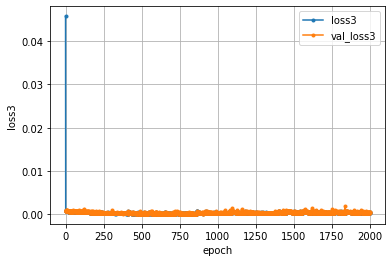

[0.045738160610198975, 0.0009294587653130293, 0.0008878486114554107, 0.0008895563660189509, 0.0008644870831631124, 0.0008608398493379354, 0.0008395833428949118, 0.0008427677676081657, 0.0008314442820847034, 0.0008345114765688777, 0.0008059440879151225, 0.0008123938459903002, 0.0007878565229475498, 0.0008044778951443732, 0.0007501911022700369, 0.0007611659821122885, 0.0007182419649325311, 0.0007199394167400897, 0.000699113414157182, 0.0006901436718180776, 0.0006661233492195606, 0.0006424072780646384, 0.0006586362142115831, 0.0006247463170439005, 0.0006446948391385376, 0.0006398926489055157, 0.0006212305743247271, 0.000628631270956248, 0.000619090860709548, 0.0006093151750974357, 0.00062071398133412, 0.0006368195172399282, 0.0005971950013190508, 0.0006413744413293898, 0.0006216465844772756, 0.0006249927682802081, 0.0005968670011498034, 0.0006261504022404552, 0.0005927088786847889, 0.0006161111523397267, 0.0006036879494786263, 0.0006069241790100932, 0.0006040328298695385, 0.00061557040316

In [44]:
# 学習経過の可視化(大きさ)
loss3     = history3.history['loss']
val_loss3 = history3.history['val_loss']

nb_epoch = len(loss3)
plt.plot(range(nb_epoch), loss3,     marker='.', label='loss3')
plt.plot(range(nb_epoch), val_loss3, marker='.', label='val_loss3')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss3')
plt.show()
print(loss3)

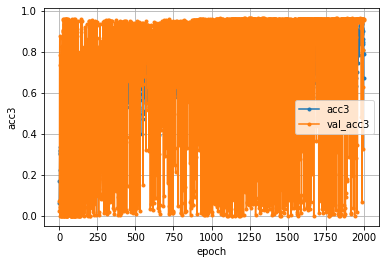

In [45]:
x# 学習経過の可視化(大きさ)
acc3     = history3.history['acc']
val_acc3 = history3.history['val_acc']

nb_epoch = len(acc3)
plt.plot(range(nb_epoch), acc3,     marker='.', label='acc3')
plt.plot(range(nb_epoch), val_acc3, marker='.', label='val_acc3')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc3')
plt.show()

In [26]:
predict3 = model3.predict([x_size_test, x_position_test])
print(x_position_test[0])
print(predict3[0]-y_test[0])
print(x_position_test[1])
print(predict3[1]-y_test[1])

[[44.5]
 [21.5]]
[ 1.18845200e-01  1.20415443e-01  1.20373609e-01  1.19219349e-01
  1.20008869e-01  1.19439438e-01  1.18591799e-01  1.12626331e-01
  1.11929493e-01  1.14857857e-01  1.10532067e-01  1.11284378e-01
  1.16640423e-01  1.13476178e-01  1.16473644e-01  1.16448129e-01
  1.14296040e-01  1.10605277e-01  9.94230086e-02  8.70625673e-02
  6.92035188e-02  7.14491589e-02  6.48919493e-04 -9.76741314e-04
  1.66706741e-04 -4.34237532e-04 -4.96797264e-04  3.23832528e-02
  1.80473215e-03 -1.48837669e-02 -1.52488451e-02 -2.04574438e-02
 -2.49848012e-02 -3.58318039e-02 -4.80136103e-02 -5.22895804e-02
 -6.13743674e-02 -6.05962284e-02 -6.86616833e-02 -7.87922799e-02
 -9.00240907e-02 -9.66988876e-02 -1.09701327e-01 -1.19378219e-01
 -1.35571480e-01 -1.42249806e-01 -1.56545463e-01 -1.60225367e-01
 -1.68305148e-01 -1.71078413e-01]
[[29.5]
 [ 9.5]]
[ 3.93302725e-02  3.81135802e-02  4.77153646e-02  6.22293569e-02
  7.15351504e-02  8.26448970e-02  9.19337301e-02  1.06735091e-01
  1.24409130e-01  1.38

In [27]:
print(y_test[0])

[ 2.631197  2.609581  2.582744  2.521944  2.440358  2.337063  2.171674
  2.013566  1.979129  1.889566  1.767642  1.622913  1.482021  1.237357
  1.05247   0.79742   0.128597 -0.407623 -0.514515 -1.170001 -2.215696
 -1.821648  0.        0.        0.        0.        0.       -2.438798
 -1.979741 -2.00545  -1.794802 -1.379466 -1.342495 -1.878209 -2.009178
 -2.093012 -2.127801 -2.208884 -2.159616 -2.26857  -2.331988 -2.2522
 -2.31719  -2.524042 -2.604249 -2.707186 -2.917216 -3.007988 -3.072078
 -3.09285 ]


In [10]:
## データについて
import random

### データファイルのpath
no_hole_path = './../tmp_simulation/tmp_data/no_hole_data.csv'
one_hole_path = './../tmp_simulation/tmp_data/one_hole_data.csv'
four_holes_path = './../tmp_simulation/tmp_data/four_holes_data.csv'
nine_holes_path = './../tmp_simulation/tmp_data/nine_holes_data.csv'
sixteen_holes_path = './../tmp_simulation/tmp_data/sixteen_holes_data.csv'
twentyfive_holes_path = './../tmp_simulation/tmp_data/twentyfive_holes_data.csv'

### 入力データと正解データ
no_hole_data = []
x_size_data = []
x_position_data = []
y_data = []

### ファイル読み込み

#### 欠陥がない場合の温度データ
with open(no_hole_path) as f:
    for line in f:
        no_hole_data = line.split(',')[:-1]

#### データ
with open(one_hole_path) as f1:
  for line in f1:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(four_holes_path) as f2:
  for line in f2:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(nine_holes_path) as f3:
  for line in f3:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(sixteen_holes_path) as f4:
  for line in f4:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])
with open(twentyfive_holes_path) as f5:
  for line in f5:
    data_array = line.split(',')
    x_size_data.append(data_array[2])
    x_position_data.append(data_array[0:2])
    y_data.append(data_array[3:-1])

### 各配列をnp.array型にして各要素を型変換
no_hole_data = np.array(no_hole_data, dtype=float)
x_size_data = np.array(x_size_data, dtype=float)
x_position_data = np.array(x_position_data, dtype=float)
y_data = np.array(y_data, dtype=float)

### データの加工
y_data = y_data - no_hole_data

### データを2500個、5000個、7500個、10000個ランダムに選んだときのデータセット作成
y_data_array = []
x_size_data_array = []
x_position_data_array = []
y_index = []
for i in range(len(y_data)):
    y_index.append(i)
for i in range(4):
    data_count = 2500*(i+1)
    used_index = random.sample(y_index, data_count)
    used_y_data = []
    used_x_size_data = []
    used_x_position_data = []
    for i in range(len(used_index)):
        used_y_data.append(y_data[used_index[i]])
        used_x_size_data.append(x_size_data[used_index[i]])
        used_x_position_data.append(x_position_data[used_index[i]])
    y_data_array.append(used_y_data)
    x_size_data_array.append(used_x_size_data)
    x_position_data_array.append(used_x_position_data)
y_data_array = np.array(y_data_array)
x_size_data_array = np.array(x_size_data_array)
x_position_data_array = np.array(x_position_data_array)
### train用とtest用に分割(4:1)
x_size_train_array = []
x_size_test_array = []
x_position_train_array = []
x_position_test_array = []
y_train_array = []
y_test_array = []
for i in range(4):
    x_size_train, x_size_test, x_position_train, x_position_test, y_train, y_test = train_test_split(x_size_data_array[i], x_position_data_array[i], y_data_array[i], test_size=0.20)
    x_size_train_array.append(np.array(x_size_train))
    x_size_test_array.append(np.array(x_size_test))
    x_position_train_array.append(np.array(x_position_train))
    x_position_test_array.append(np.array(x_position_test))
    y_train_array.append(np.array(y_train))
    y_test_array.append(np.array(y_test))

for i in range(4):
    print(len(x_size_train_array[i]))
    print(len(x_size_test_array[i]))

### reshape
for i in range(4):
    train_count = 2000*(i+1)
    test_count = 500*(i+1)
    x_size_train_array[i].reshape(train_count, 1, 1)
    x_size_test_array[i].reshape(test_count, 1, 1)
    x_position_train_array[i].reshape(train_count, 2, 1)
    x_position_test_array[i].reshape(test_count, 2, 1)


2000
500
4000
1000
6000
1500
8000
2000


/opt/anaconda3/envs/graduation_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/anaconda3/envs/graduation_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/anaconda3/envs/graduation_thesis/lib/python3.7/site-packages/ipykernel_launcher.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant

In [11]:
# データ数の実験用コード
loss_array = []
model_array = []
history_array = []
#実験用のモデル
# 入力を定義
size_input = Input(shape=(1,))
position_input = Input(shape=(2,))

# 入力1から結合前まで
x = Dense(1, activation="linear")(size_input)
x = Model(inputs=size_input, outputs=x)

# 入力2から結合前まで
y = Dense(1, activation="linear")(position_input)
y = Model(inputs=position_input, outputs=y)

# 結合
combined = concatenate([x.output, y.output])

# 密結合
z = Dense(64, activation="linear")(combined)
z = Dense(128, activation="tanh")(z)
z = Dense(256, activation="tanh")(z)
z = Dense(128, activation="tanh")(z)
z = Dense(64, activation="tanh")(z)
z = Dense(50, activation="linear")(z)

# モデル定義とコンパイル
for i in range(4):
    model_array.append(Model(inputs=[x.input, y.input], outputs=z))
    model_array[i].compile(loss='mse', optimizer='adam', metrics=['acc'])

In [12]:
# 学習ループ
history_array = []
for i in range(len(model_array)):
    epochs = 1000
    batch_size = 128
    history_array.append(model_array[i].fit([x_size_train_array[i], x_position_train_array[i]], y_train_array[i], batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_size_test_array[i], x_position_test_array[i]], y_test_array[i])))

Epoch 1/1000
16/16 [==============================] - 0s 10ms/step - loss: 2.8036 - acc: 0.1075 - val_loss: 1.1435 - val_acc: 0.5540
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.9190 - acc: 0.9130 - val_loss: 0.3507 - val_acc: 0.9860
Epoch 3/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.4976 - acc: 0.7270 - val_loss: 0.2373 - val_acc: 0.3960
Epoch 4/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.4505 - acc: 0.1330 - val_loss: 0.2292 - val_acc: 0.0020
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.4409 - acc: 0.1950 - val_loss: 0.2200 - val_acc: 0.4620
Epoch 6/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.4346 - acc: 0.6410 - val_loss: 0.2172 - val_acc: 0.5200
Epoch 7/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.4305 - acc: 0.4830 - val_loss: 0.2162 - val_acc: 0.5560
Epoch 8/1000
16/16 [==============================] - 0s 4ms/step - loss: 0

16/16 [==============================] - 0s 3ms/step - loss: 0.3033 - acc: 0.7240 - val_loss: 0.1578 - val_acc: 0.7640
Epoch 124/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.3120 - acc: 0.7270 - val_loss: 0.1670 - val_acc: 0.9080
Epoch 125/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.3075 - acc: 0.7915 - val_loss: 0.1614 - val_acc: 0.6740
Epoch 126/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.3103 - acc: 0.7570 - val_loss: 0.1545 - val_acc: 0.9000
Epoch 127/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.3250 - acc: 0.7795 - val_loss: 0.1735 - val_acc: 0.8980
Epoch 128/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.3285 - acc: 0.7875 - val_loss: 0.1626 - val_acc: 0.9220
Epoch 129/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.3079 - acc: 0.7550 - val_loss: 0.1393 - val_acc: 0.8960
Epoch 130/1000
16/16 [==============================] - 0s 3ms/step - loss: 0

16/16 [==============================] - 0s 3ms/step - loss: 0.2851 - acc: 0.7255 - val_loss: 0.1548 - val_acc: 0.6920
Epoch 246/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2863 - acc: 0.6470 - val_loss: 0.1510 - val_acc: 0.4300
Epoch 247/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2856 - acc: 0.8270 - val_loss: 0.1573 - val_acc: 0.4740
Epoch 248/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2806 - acc: 0.8040 - val_loss: 0.1522 - val_acc: 0.9020
Epoch 249/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2852 - acc: 0.6240 - val_loss: 0.1588 - val_acc: 0.9260
Epoch 250/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2835 - acc: 0.6305 - val_loss: 0.1593 - val_acc: 0.9200
Epoch 251/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2813 - acc: 0.5815 - val_loss: 0.1594 - val_acc: 0.2060
Epoch 252/1000
16/16 [==============================] - 0s 3ms/step - loss: 0

16/16 [==============================] - 0s 3ms/step - loss: 0.3099 - acc: 0.8935 - val_loss: 0.1556 - val_acc: 0.9100
Epoch 368/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.3122 - acc: 0.8785 - val_loss: 0.1440 - val_acc: 0.9140
Epoch 369/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.3014 - acc: 0.8985 - val_loss: 0.1495 - val_acc: 0.9140
Epoch 370/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.3110 - acc: 0.8990 - val_loss: 0.1578 - val_acc: 0.9020
Epoch 371/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.3026 - acc: 0.9030 - val_loss: 0.1648 - val_acc: 0.8920
Epoch 372/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2954 - acc: 0.8890 - val_loss: 0.1538 - val_acc: 0.8800
Epoch 373/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2903 - acc: 0.9000 - val_loss: 0.1639 - val_acc: 0.9140
Epoch 374/1000
16/16 [==============================] - 0s 3ms/step - loss: 0

16/16 [==============================] - 0s 4ms/step - loss: 0.2565 - acc: 0.9375 - val_loss: 0.1732 - val_acc: 0.9540
Epoch 490/1000
16/16 [==============================] - ETA: 0s - loss: 0.1465 - acc: 0.914 - 0s 4ms/step - loss: 0.2522 - acc: 0.9410 - val_loss: 0.1842 - val_acc: 0.9440
Epoch 491/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2439 - acc: 0.9380 - val_loss: 0.1823 - val_acc: 0.9540
Epoch 492/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2479 - acc: 0.9340 - val_loss: 0.1837 - val_acc: 0.9420
Epoch 493/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2839 - acc: 0.9400 - val_loss: 0.1657 - val_acc: 0.9700
Epoch 494/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2839 - acc: 0.9500 - val_loss: 0.1592 - val_acc: 0.9580
Epoch 495/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2589 - acc: 0.9400 - val_loss: 0.1756 - val_acc: 0.9520
Epoch 496/1000
16/16 [=================

Epoch 550/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2525 - acc: 0.9345 - val_loss: 0.1723 - val_acc: 0.9480
Epoch 551/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2633 - acc: 0.9360 - val_loss: 0.1505 - val_acc: 0.9480
Epoch 552/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2985 - acc: 0.9395 - val_loss: 0.1656 - val_acc: 0.9600
Epoch 553/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2653 - acc: 0.9440 - val_loss: 0.1564 - val_acc: 0.9480
Epoch 554/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2603 - acc: 0.9345 - val_loss: 0.1617 - val_acc: 0.9360
Epoch 555/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2568 - acc: 0.9285 - val_loss: 0.1659 - val_acc: 0.9380
Epoch 556/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2507 - acc: 0.9300 - val_loss: 0.1605 - val_acc: 0.9440
Epoch 557/1000
16/16 [==============================] - 0s 4ms

16/16 [==============================] - 0s 4ms/step - loss: 0.2651 - acc: 0.9195 - val_loss: 0.1739 - val_acc: 0.9460
Epoch 673/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2675 - acc: 0.9255 - val_loss: 0.1664 - val_acc: 0.9520
Epoch 674/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2630 - acc: 0.9255 - val_loss: 0.1662 - val_acc: 0.9520
Epoch 675/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2544 - acc: 0.9245 - val_loss: 0.1687 - val_acc: 0.9440
Epoch 676/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2468 - acc: 0.9325 - val_loss: 0.1866 - val_acc: 0.9600
Epoch 677/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2476 - acc: 0.9300 - val_loss: 0.1744 - val_acc: 0.9460
Epoch 678/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2376 - acc: 0.9225 - val_loss: 0.1710 - val_acc: 0.9480
Epoch 679/1000
16/16 [==============================] - 0s 4ms/step - loss: 0

16/16 [==============================] - 0s 4ms/step - loss: 0.2629 - acc: 0.9270 - val_loss: 0.1696 - val_acc: 0.9480
Epoch 795/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2593 - acc: 0.9160 - val_loss: 0.1750 - val_acc: 0.9500
Epoch 796/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2516 - acc: 0.9175 - val_loss: 0.1751 - val_acc: 0.9400
Epoch 797/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2450 - acc: 0.9145 - val_loss: 0.1719 - val_acc: 0.9460
Epoch 798/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2450 - acc: 0.9205 - val_loss: 0.1800 - val_acc: 0.9480
Epoch 799/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2386 - acc: 0.9230 - val_loss: 0.1853 - val_acc: 0.9340
Epoch 800/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.2356 - acc: 0.9150 - val_loss: 0.1572 - val_acc: 0.9420
Epoch 801/1000
16/16 [==============================] - 0s 3ms/step - loss: 0

16/16 [==============================] - 0s 4ms/step - loss: 0.2948 - acc: 0.9160 - val_loss: 0.1392 - val_acc: 0.9280
Epoch 917/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2836 - acc: 0.9180 - val_loss: 0.1510 - val_acc: 0.9380
Epoch 918/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2943 - acc: 0.8885 - val_loss: 0.1607 - val_acc: 0.9180
Epoch 919/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2783 - acc: 0.8970 - val_loss: 0.1506 - val_acc: 0.8060
Epoch 920/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2678 - acc: 0.9005 - val_loss: 0.1509 - val_acc: 0.9560
Epoch 921/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2672 - acc: 0.8840 - val_loss: 0.1503 - val_acc: 0.9560
Epoch 922/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.2602 - acc: 0.9395 - val_loss: 0.1429 - val_acc: 0.9620
Epoch 923/1000
16/16 [==============================] - 0s 4ms/step - loss: 0

32/32 [==============================] - 0s 3ms/step - loss: 0.2143 - acc: 0.8265 - val_loss: 0.2075 - val_acc: 0.9320
Epoch 39/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2269 - acc: 0.8737 - val_loss: 0.2026 - val_acc: 0.8700
Epoch 40/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2195 - acc: 0.8898 - val_loss: 0.2053 - val_acc: 0.9560
Epoch 41/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2305 - acc: 0.7822 - val_loss: 0.2229 - val_acc: 0.6150
Epoch 42/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2222 - acc: 0.8533 - val_loss: 0.1966 - val_acc: 0.9230
Epoch 43/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2156 - acc: 0.8460 - val_loss: 0.2035 - val_acc: 0.9340
Epoch 44/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2137 - acc: 0.8708 - val_loss: 0.2016 - val_acc: 0.9400
Epoch 45/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2135 -

Epoch 100/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2240 - acc: 0.9018 - val_loss: 0.2089 - val_acc: 0.9270
Epoch 101/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2310 - acc: 0.8045 - val_loss: 0.2053 - val_acc: 0.9640
Epoch 102/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2256 - acc: 0.9158 - val_loss: 0.2202 - val_acc: 0.9490
Epoch 103/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2194 - acc: 0.8438 - val_loss: 0.2088 - val_acc: 0.9500
Epoch 104/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2190 - acc: 0.9480 - val_loss: 0.1994 - val_acc: 0.9600
Epoch 105/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2101 - acc: 0.9467 - val_loss: 0.1941 - val_acc: 0.9490
Epoch 106/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2154 - acc: 0.9430 - val_loss: 0.1988 - val_acc: 0.9400
Epoch 107/1000
32/32 [==============================] - 0s 3ms

32/32 [==============================] - 0s 4ms/step - loss: 0.2048 - acc: 0.9482 - val_loss: 0.1870 - val_acc: 0.9630
Epoch 223/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.2046 - acc: 0.9470 - val_loss: 0.2009 - val_acc: 0.9650
Epoch 224/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.2053 - acc: 0.9498 - val_loss: 0.1947 - val_acc: 0.9650
Epoch 225/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.2013 - acc: 0.9510 - val_loss: 0.2072 - val_acc: 0.9600
Epoch 226/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1999 - acc: 0.9392 - val_loss: 0.2056 - val_acc: 0.9340
Epoch 227/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1981 - acc: 0.9398 - val_loss: 0.2097 - val_acc: 0.9500
Epoch 228/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.2083 - acc: 0.9335 - val_loss: 0.2134 - val_acc: 0.9630
Epoch 229/1000
32/32 [==============================] - 0s 4ms/step - loss: 0

32/32 [==============================] - 0s 4ms/step - loss: 0.1972 - acc: 0.9335 - val_loss: 0.1927 - val_acc: 0.9470
Epoch 345/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1952 - acc: 0.9358 - val_loss: 0.1985 - val_acc: 0.9510
Epoch 346/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2137 - acc: 0.9373 - val_loss: 0.2062 - val_acc: 0.9410
Epoch 347/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2089 - acc: 0.9277 - val_loss: 0.2035 - val_acc: 0.9360
Epoch 348/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1944 - acc: 0.9290 - val_loss: 0.2026 - val_acc: 0.9460
Epoch 349/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1921 - acc: 0.9337 - val_loss: 0.2025 - val_acc: 0.9470
Epoch 350/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2045 - acc: 0.9435 - val_loss: 0.1999 - val_acc: 0.9570
Epoch 351/1000
32/32 [==============================] - 0s 3ms/step - loss: 0

32/32 [==============================] - 0s 4ms/step - loss: 0.1907 - acc: 0.9405 - val_loss: 0.1931 - val_acc: 0.9440
Epoch 467/1000
32/32 [==============================] - 0s 4ms/step - loss: 0.2044 - acc: 0.9362 - val_loss: 0.2026 - val_acc: 0.9430
Epoch 468/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2049 - acc: 0.9373 - val_loss: 0.1981 - val_acc: 0.9570
Epoch 469/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1878 - acc: 0.9340 - val_loss: 0.2079 - val_acc: 0.8500
Epoch 470/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2054 - acc: 0.9427 - val_loss: 0.2020 - val_acc: 0.9620
Epoch 471/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2002 - acc: 0.9082 - val_loss: 0.2040 - val_acc: 0.9420
Epoch 472/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1944 - acc: 0.9342 - val_loss: 0.1944 - val_acc: 0.9560
Epoch 473/1000
32/32 [==============================] - 0s 3ms/step - loss: 0

32/32 [==============================] - 0s 3ms/step - loss: 0.2074 - acc: 0.9560 - val_loss: 0.1885 - val_acc: 0.9680
Epoch 589/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2080 - acc: 0.9563 - val_loss: 0.1841 - val_acc: 0.9720
Epoch 590/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2080 - acc: 0.9570 - val_loss: 0.1881 - val_acc: 0.9740
Epoch 591/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2084 - acc: 0.9553 - val_loss: 0.1827 - val_acc: 0.9700
Epoch 592/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2079 - acc: 0.9578 - val_loss: 0.1907 - val_acc: 0.9680
Epoch 593/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2072 - acc: 0.9572 - val_loss: 0.1794 - val_acc: 0.9730
Epoch 594/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2068 - acc: 0.9580 - val_loss: 0.1949 - val_acc: 0.9650
Epoch 595/1000
32/32 [==============================] - 0s 4ms/step - loss: 0

32/32 [==============================] - 0s 3ms/step - loss: 0.2065 - acc: 0.9435 - val_loss: 0.1853 - val_acc: 0.9560
Epoch 711/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2031 - acc: 0.9395 - val_loss: 0.1844 - val_acc: 0.9600
Epoch 712/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2047 - acc: 0.9455 - val_loss: 0.1898 - val_acc: 0.9580
Epoch 713/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1980 - acc: 0.9448 - val_loss: 0.1925 - val_acc: 0.9620
Epoch 714/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1974 - acc: 0.9523 - val_loss: 0.1908 - val_acc: 0.9650
Epoch 715/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2031 - acc: 0.9498 - val_loss: 0.1898 - val_acc: 0.9570
Epoch 716/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1955 - acc: 0.9513 - val_loss: 0.1885 - val_acc: 0.9580
Epoch 717/1000
32/32 [==============================] - 0s 3ms/step - loss: 0

32/32 [==============================] - 0s 3ms/step - loss: 0.1992 - acc: 0.9415 - val_loss: 0.1776 - val_acc: 0.9680
Epoch 833/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1918 - acc: 0.9515 - val_loss: 0.1731 - val_acc: 0.9650
Epoch 834/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2167 - acc: 0.9262 - val_loss: 0.1909 - val_acc: 0.9640
Epoch 835/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1991 - acc: 0.9498 - val_loss: 0.1788 - val_acc: 0.9660
Epoch 836/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.1929 - acc: 0.9517 - val_loss: 0.1697 - val_acc: 0.9630
Epoch 837/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2075 - acc: 0.9503 - val_loss: 0.1738 - val_acc: 0.9600
Epoch 838/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2027 - acc: 0.9528 - val_loss: 0.1835 - val_acc: 0.9650
Epoch 839/1000
32/32 [==============================] - 0s 3ms/step - loss: 0

32/32 [==============================] - 0s 3ms/step - loss: 0.2040 - acc: 0.8645 - val_loss: 0.1669 - val_acc: 0.9580
Epoch 955/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2008 - acc: 0.9515 - val_loss: 0.1634 - val_acc: 0.9580
Epoch 956/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2004 - acc: 0.9520 - val_loss: 0.1652 - val_acc: 0.9590
Epoch 957/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2280 - acc: 0.9498 - val_loss: 0.1750 - val_acc: 0.8230
Epoch 958/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2221 - acc: 0.9060 - val_loss: 0.1723 - val_acc: 0.9620
Epoch 959/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2163 - acc: 0.7615 - val_loss: 0.1705 - val_acc: 0.9650
Epoch 960/1000
32/32 [==============================] - 0s 3ms/step - loss: 0.2110 - acc: 0.7168 - val_loss: 0.1709 - val_acc: 0.9730
Epoch 961/1000
32/32 [==============================] - 0s 3ms/step - loss: 0

Epoch 77/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1091 - acc: 0.9522 - val_loss: 0.1423 - val_acc: 0.9353
Epoch 78/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1077 - acc: 0.9473 - val_loss: 0.0969 - val_acc: 0.9453
Epoch 79/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1018 - acc: 0.9522 - val_loss: 0.1138 - val_acc: 0.9467
Epoch 80/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1008 - acc: 0.9513 - val_loss: 0.0967 - val_acc: 0.9487
Epoch 81/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.0940 - acc: 0.9538 - val_loss: 0.0900 - val_acc: 0.9500
Epoch 82/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.0935 - acc: 0.9537 - val_loss: 0.1063 - val_acc: 0.9500
Epoch 83/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1013 - acc: 0.9548 - val_loss: 0.0901 - val_acc: 0.9467
Epoch 84/1000
47/47 [==============================] - 0s 3ms/step - 

47/47 [==============================] - 0s 3ms/step - loss: 0.2769 - acc: 0.9228 - val_loss: 0.3057 - val_acc: 0.9380
Epoch 200/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2772 - acc: 0.9322 - val_loss: 0.2950 - val_acc: 0.9227
Epoch 201/1000
47/47 [==============================] - 0s 4ms/step - loss: 0.2724 - acc: 0.9378 - val_loss: 0.3002 - val_acc: 0.9407
Epoch 202/1000
47/47 [==============================] - 0s 4ms/step - loss: 0.2837 - acc: 0.9373 - val_loss: 0.3114 - val_acc: 0.8933
Epoch 203/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2843 - acc: 0.9400 - val_loss: 0.3069 - val_acc: 0.9520
Epoch 204/1000
47/47 [==============================] - 0s 4ms/step - loss: 0.2793 - acc: 0.9460 - val_loss: 0.2944 - val_acc: 0.9427
Epoch 205/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2664 - acc: 0.9463 - val_loss: 0.2917 - val_acc: 0.9453
Epoch 206/1000
47/47 [==============================] - 0s 3ms/step - loss: 0

47/47 [==============================] - 0s 3ms/step - loss: 0.2042 - acc: 0.9648 - val_loss: 0.2158 - val_acc: 0.9647
Epoch 322/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2031 - acc: 0.9645 - val_loss: 0.2374 - val_acc: 0.9647
Epoch 323/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2714 - acc: 0.9633 - val_loss: 0.4596 - val_acc: 0.9600
Epoch 324/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.3341 - acc: 0.9597 - val_loss: 0.3198 - val_acc: 0.9553
Epoch 325/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2974 - acc: 0.9483 - val_loss: 0.3398 - val_acc: 0.9340
Epoch 326/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.3118 - acc: 0.9393 - val_loss: 0.3452 - val_acc: 0.9573
Epoch 327/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.3055 - acc: 0.9555 - val_loss: 0.3413 - val_acc: 0.9573
Epoch 328/1000
47/47 [==============================] - 0s 3ms/step - loss: 0

47/47 [==============================] - 0s 3ms/step - loss: 0.2698 - acc: 0.9630 - val_loss: 0.3192 - val_acc: 0.9567
Epoch 444/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2739 - acc: 0.9627 - val_loss: 0.3596 - val_acc: 0.9627
Epoch 445/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2806 - acc: 0.9615 - val_loss: 0.3314 - val_acc: 0.9627
Epoch 446/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2710 - acc: 0.9637 - val_loss: 0.3096 - val_acc: 0.9607
Epoch 447/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2695 - acc: 0.9622 - val_loss: 0.3216 - val_acc: 0.9593
Epoch 448/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2749 - acc: 0.9627 - val_loss: 0.3317 - val_acc: 0.9627
Epoch 449/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2764 - acc: 0.9628 - val_loss: 0.3266 - val_acc: 0.9627
Epoch 450/1000
47/47 [==============================] - 0s 3ms/step - loss: 0

47/47 [==============================] - 0s 3ms/step - loss: 0.2402 - acc: 0.9635 - val_loss: 0.2267 - val_acc: 0.9620
Epoch 566/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2065 - acc: 0.9635 - val_loss: 0.2138 - val_acc: 0.9627
Epoch 567/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2027 - acc: 0.9637 - val_loss: 0.2095 - val_acc: 0.9627
Epoch 568/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2553 - acc: 0.9645 - val_loss: 0.3146 - val_acc: 0.9647
Epoch 569/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2450 - acc: 0.9642 - val_loss: 0.5054 - val_acc: 0.9647
Epoch 570/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.3612 - acc: 0.9652 - val_loss: 0.3777 - val_acc: 0.9647
Epoch 571/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2856 - acc: 0.9653 - val_loss: 0.3360 - val_acc: 0.9647
Epoch 572/1000
47/47 [==============================] - 0s 3ms/step - loss: 0

47/47 [==============================] - 0s 3ms/step - loss: 0.1797 - acc: 0.9633 - val_loss: 0.2004 - val_acc: 0.9627
Epoch 688/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1836 - acc: 0.9637 - val_loss: 0.2181 - val_acc: 0.9620
Epoch 689/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1818 - acc: 0.9637 - val_loss: 0.2106 - val_acc: 0.9620
Epoch 690/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1900 - acc: 0.9640 - val_loss: 0.1978 - val_acc: 0.9620
Epoch 691/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1822 - acc: 0.9638 - val_loss: 0.2114 - val_acc: 0.9633
Epoch 692/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1752 - acc: 0.9633 - val_loss: 0.1893 - val_acc: 0.9647
Epoch 693/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1909 - acc: 0.9632 - val_loss: 0.3173 - val_acc: 0.9620
Epoch 694/1000
47/47 [==============================] - 0s 3ms/step - loss: 0

47/47 [==============================] - 0s 3ms/step - loss: 0.1609 - acc: 0.9647 - val_loss: 0.1685 - val_acc: 0.9647
Epoch 810/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2179 - acc: 0.9647 - val_loss: 0.1778 - val_acc: 0.9620
Epoch 811/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1733 - acc: 0.9645 - val_loss: 0.1681 - val_acc: 0.9640
Epoch 812/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1675 - acc: 0.9640 - val_loss: 0.1843 - val_acc: 0.9680
Epoch 813/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1960 - acc: 0.9653 - val_loss: 0.2595 - val_acc: 0.9667
Epoch 814/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1866 - acc: 0.9650 - val_loss: 0.1910 - val_acc: 0.9680
Epoch 815/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1569 - acc: 0.9650 - val_loss: 0.1776 - val_acc: 0.9693
Epoch 816/1000
47/47 [==============================] - 0s 3ms/step - loss: 0

47/47 [==============================] - 0s 3ms/step - loss: 0.1762 - acc: 0.9188 - val_loss: 0.2574 - val_acc: 0.9540
Epoch 932/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1677 - acc: 0.9625 - val_loss: 0.1826 - val_acc: 0.9647
Epoch 933/1000
47/47 [==============================] - 0s 4ms/step - loss: 0.1787 - acc: 0.9625 - val_loss: 0.2037 - val_acc: 0.9600
Epoch 934/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1711 - acc: 0.9610 - val_loss: 0.1931 - val_acc: 0.9553
Epoch 935/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.2129 - acc: 0.9413 - val_loss: 0.1988 - val_acc: 0.9627
Epoch 936/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.1689 - acc: 0.9477 - val_loss: 0.2298 - val_acc: 0.9613
Epoch 937/1000
47/47 [==============================] - 0s 3ms/step - loss: 0.3000 - acc: 0.8868 - val_loss: 0.3864 - val_acc: 0.9647
Epoch 938/1000
47/47 [==============================] - 0s 3ms/step - loss: 0

Epoch 54/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1827 - acc: 0.9544 - val_loss: 0.1467 - val_acc: 0.9465
Epoch 55/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1721 - acc: 0.9535 - val_loss: 0.3276 - val_acc: 0.9450
Epoch 56/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1866 - acc: 0.9542 - val_loss: 0.1312 - val_acc: 0.9490
Epoch 57/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1648 - acc: 0.9548 - val_loss: 0.1375 - val_acc: 0.9465
Epoch 58/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1777 - acc: 0.9553 - val_loss: 0.1672 - val_acc: 0.9465
Epoch 59/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1757 - acc: 0.9511 - val_loss: 0.1277 - val_acc: 0.9450
Epoch 60/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1432 - acc: 0.9521 - val_loss: 0.1238 - val_acc: 0.9470
Epoch 61/1000
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 0.2104 - acc: 0.9159 - val_loss: 0.1877 - val_acc: 0.9290
Epoch 177/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2179 - acc: 0.9335 - val_loss: 0.1965 - val_acc: 0.9285
Epoch 178/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2088 - acc: 0.9385 - val_loss: 0.2021 - val_acc: 0.9320
Epoch 179/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2083 - acc: 0.9430 - val_loss: 0.1995 - val_acc: 0.9305
Epoch 180/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2031 - acc: 0.9386 - val_loss: 0.1861 - val_acc: 0.9335
Epoch 181/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2026 - acc: 0.9431 - val_loss: 0.2156 - val_acc: 0.9525
Epoch 182/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2158 - acc: 0.9185 - val_loss: 0.1923 - val_acc: 0.9310
Epoch 183/1000
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.1335 - acc: 0.9559 - val_loss: 0.1310 - val_acc: 0.9505
Epoch 299/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.3072 - acc: 0.9503 - val_loss: 0.2577 - val_acc: 0.9420
Epoch 300/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2512 - acc: 0.9501 - val_loss: 0.2308 - val_acc: 0.9520
Epoch 301/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1915 - acc: 0.9630 - val_loss: 0.1675 - val_acc: 0.9655
Epoch 302/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1857 - acc: 0.9654 - val_loss: 0.1622 - val_acc: 0.9650
Epoch 303/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1714 - acc: 0.9628 - val_loss: 0.1491 - val_acc: 0.9550
Epoch 304/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1622 - acc: 0.9634 - val_loss: 0.1492 - val_acc: 0.9570
Epoch 305/1000
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.0964 - acc: 0.9546 - val_loss: 0.0825 - val_acc: 0.9480
Epoch 421/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.0960 - acc: 0.9556 - val_loss: 0.1008 - val_acc: 0.9470
Epoch 422/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1084 - acc: 0.9550 - val_loss: 0.1389 - val_acc: 0.9470
Epoch 423/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2553 - acc: 0.9532 - val_loss: 0.1925 - val_acc: 0.9450
Epoch 424/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1808 - acc: 0.9578 - val_loss: 0.1507 - val_acc: 0.9585
Epoch 425/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1336 - acc: 0.9542 - val_loss: 0.1089 - val_acc: 0.9465
Epoch 426/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1195 - acc: 0.9536 - val_loss: 0.1246 - val_acc: 0.9480
Epoch 427/1000
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.0981 - acc: 0.9664 - val_loss: 0.0784 - val_acc: 0.9655
Epoch 543/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.0826 - acc: 0.9680 - val_loss: 0.0741 - val_acc: 0.9655
Epoch 544/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.0807 - acc: 0.9685 - val_loss: 0.0803 - val_acc: 0.9630
Epoch 545/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.0806 - acc: 0.9678 - val_loss: 0.0776 - val_acc: 0.9660
Epoch 546/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1154 - acc: 0.9671 - val_loss: 0.0803 - val_acc: 0.9685
Epoch 547/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.0885 - acc: 0.9679 - val_loss: 0.0941 - val_acc: 0.9645
Epoch 548/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1014 - acc: 0.9684 - val_loss: 0.0818 - val_acc: 0.9650
Epoch 549/1000
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.1630 - acc: 0.9664 - val_loss: 0.1602 - val_acc: 0.9660
Epoch 665/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1731 - acc: 0.9665 - val_loss: 0.1397 - val_acc: 0.9635
Epoch 666/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1734 - acc: 0.9653 - val_loss: 0.1554 - val_acc: 0.9625
Epoch 667/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1524 - acc: 0.9656 - val_loss: 0.1549 - val_acc: 0.9620
Epoch 668/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1470 - acc: 0.9661 - val_loss: 0.1461 - val_acc: 0.9625
Epoch 669/1000
63/63 [==============================] - 0s 4ms/step - loss: 0.1716 - acc: 0.9661 - val_loss: 0.1996 - val_acc: 0.9570
Epoch 670/1000
63/63 [==============================] - 0s 4ms/step - loss: 0.1771 - acc: 0.9647 - val_loss: 0.1438 - val_acc: 0.9615
Epoch 671/1000
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.2084 - acc: 0.9629 - val_loss: 0.1557 - val_acc: 0.9615
Epoch 787/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1763 - acc: 0.9643 - val_loss: 0.1461 - val_acc: 0.9630
Epoch 788/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1756 - acc: 0.9644 - val_loss: 0.1663 - val_acc: 0.9635
Epoch 789/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1607 - acc: 0.9646 - val_loss: 0.1738 - val_acc: 0.9565
Epoch 790/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1989 - acc: 0.9645 - val_loss: 0.1506 - val_acc: 0.9605
Epoch 791/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1603 - acc: 0.9643 - val_loss: 0.1504 - val_acc: 0.9615
Epoch 792/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1657 - acc: 0.9640 - val_loss: 0.1382 - val_acc: 0.9645
Epoch 793/1000
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.1904 - acc: 0.9634 - val_loss: 0.1596 - val_acc: 0.9630
Epoch 909/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.2076 - acc: 0.9655 - val_loss: 0.1724 - val_acc: 0.9645
Epoch 910/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1910 - acc: 0.9657 - val_loss: 0.1504 - val_acc: 0.9625
Epoch 911/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1741 - acc: 0.9655 - val_loss: 0.1460 - val_acc: 0.9640
Epoch 912/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1817 - acc: 0.9646 - val_loss: 0.1517 - val_acc: 0.9630
Epoch 913/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1680 - acc: 0.9656 - val_loss: 0.1332 - val_acc: 0.9630
Epoch 914/1000
63/63 [==============================] - 0s 3ms/step - loss: 0.1671 - acc: 0.9651 - val_loss: 0.1390 - val_acc: 0.9635
Epoch 915/1000
63/63 [==============================] - 0s 3ms/step - loss: 0

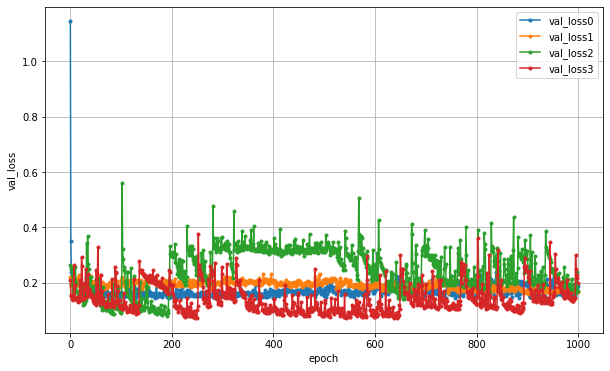

In [13]:
# 学習経過の可視化(大きさ)

val_loss_array = []
for i in range(len(history_array)):
    val_loss_array.append(history_array[i].history['val_loss'])
plt.figure(figsize=(10,6))
nb_epoch = len(val_loss_array[i])
for i in range(len(val_loss_array)):
    plt.plot(range(nb_epoch), val_loss_array[i], marker='.', label='val_loss%d'%i)
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.show()
